In [120]:
from __future__ import division

import numpy as np
import os, sys
from PIL import Image
import pandas as pd
import json
import pickle

from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

from IPython.core.pylabtools import figsize, getfigs

import seaborn as sns

import random

from scipy.stats import norm
from IPython.display import clear_output

import copy
import importlib


### Add Paths

## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..')) ## use relative paths

## add helpers to python path
import sys
if os.path.join(proj_dir, 'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'stimuli'))

## import utils from git submodule
sys.path.append("./block_utils/")
import blockworld_utils as utils

In [121]:
importlib.reload(utils)

<module 'blockworld_utils' from './block_utils/blockworld_utils.py'>

In [4]:
# setup
block_dims = [(2,1),(1,2)]
block_colors = ['#B32F0A','#0A2FB3']
black = ['#000000','#000000'] # used to display silhouettes
grey = ['#333333','#333333']
world_width = 8
world_height = 8
world_center = int((world_width-1)/2)

# convert dictionary representations of towers to (hashable) tuple and back
def world_dicts_to_tuples(wd):
    wt = tuple((block['x'],block['y'],block['height'],block['width']) for block in wd)
    return wt

def world_tuples_to_dicts(wt):
    wd = [{'x': block[0],
             'y': block[1],
             'height': block[2],
             'width': block[3]} for block in wt]
    return wd


# helper functions to reduce set of towers

def sort_blocks(stim_list):
    # sort the blocks within a tower to find unique towers
    sorted_list = [sorted(tower, key = lambda block: (block['y'],block['x'],block['height'],block['width'])) # SWAPPED X AND Y POSITIONS IN TUPLE HERE
     for tower in stim_list]
    
    return sorted_list


def align_towers(stim_list):
    # place leftmost block in position 0
    # by subtracting min x ordinate from all x-values

    min_xs = [min([block['x'] for block in tower]) for tower in stim_list]

    aligned_towers = [[{'x': block['x'] - min_x,
       'y': block['y'],
       'height': block['height'],
       'width': block['width']}
      for block in tower] for (tower, min_x) in zip(stim_list, min_xs)]
    
    return aligned_towers

def convert_to_tuples(stim_list):
    return [world_dicts_to_tuples(tower) for tower in stim_list]

def find_unique_towers(stim_list):
    return set(stim_list)


### Functions for combining towers

In [5]:
def compose_vertically(stim_a, stim_b): 
    
    world = utils.worldify(stim_a, 
                         block_dims = block_dims, 
                         block_colors = block_colors,)

    tower_a_height = world.tower_height()
    
    still_good = True
    
    for block in stim_b:
        placed_block = world.snap_to_floor(block['width'], block['height'], block['x'])
#         print(placed_block.y)
#         print(block['y']+tower_a_height)
#         print('this block good: ' + str(placed_block.y == (block['y'] + tower_a_height)))
        still_good = still_good and (placed_block.y == (block['y'] + tower_a_height))
#         print(still_good)
        
    return (still_good, world)


In [88]:
# compose horizontally

def compose_horizontally(stim_a, stim_b, keep_separable=True): 
    '''
    Composes two tall stimuli by placing them side by side.
    
    Tries placing tower 1, then 2 blocks to the right of it's left-aligned position.

    Rejects tower if width > 4 squares
    
    
    Want to assume that if you can build the towers one after the other, you can build them the other way around
    This should work given that each is an independent standing tower, but:
    NEED TO CHECK THAT IN EXPERIMENT YOU CAN SNAP A BLOCK UNDER ANOTHER IF NEEDED
    
    PRE: stims are maximum 3 wide
    '''
    
    still_good = False
    successful_alignment = None
    
    if keep_separable:
        alignments = [2]
    else:
        alignments = [1,2]
    
    for alignment in alignments:
        
        if still_good == False:

            # Try placing left tower first
            world = utils.worldify(stim_a, 
                                 block_dims = block_dims, 
                                 block_colors = block_colors,)

            still_good = True

            for block in stim_b:
                # place block 'alignment' squares to the right of its default position
                placed_block = world.snap_to_floor(block['width'], block['height'], block['x'] + alignment)
                # if it stays at the predefined height, we're good
                still_good = still_good and (placed_block.y == (block['y']))


            if not still_good:
                # Try placing right tower
                
                realigned_tower = [{'x': b['x'] + alignment,
                                     'y': b['y'],
                                     'height': b['height'],
                                     'width': b['width']}
                                              for b in stim_b]

                world = utils.worldify(realigned_tower, 
                                     block_dims = block_dims, 
                                     block_colors = block_colors,)

                still_good = True

                for block in stim_a:
                    # place block 'alignment' squares to the right of its default position
                    placed_block = world.snap_to_floor(block['width'], block['height'], block['x'])
                    # if it stays at the predefined height, we're good
                    still_good = still_good and (placed_block.y == (block['y']))
                    
                still_good = still_good and world.tower_width() <=4
                    
                
                
                if not still_good:
                    # try sorting
                    
                    stim_a_copy = stim_a.copy()
                    
                    sorted_stims = sort_blocks([stim_a_copy + realigned_tower])[0]

                    world = utils.World(block_dims = block_dims, 
                                        block_colors = block_colors,)
                    still_good = True

                    for block in sorted_stims:
                        # place block 'alignment' squares to the right of its default position
                        placed_block = world.snap_to_floor(block['width'], block['height'], block['x'])
                        # if it stays at the predefined height, we're good
                        still_good = still_good and (placed_block.y == (block['y']))
                
                


            still_good = still_good and world.tower_width() <=4
            
            if still_good:
                successful_alignment = alignment
            

    return (still_good, world, successful_alignment)



## Create set of 4-block towers

In [7]:
# generate stims

max_blocks = 5

stims = {}

# single block in center of world
stims[1] = []

for block in block_dims:
    w = utils.World(block_dims = block_dims,
                block_colors = block_colors)
    w.add_block(block[0], # width
                block[1], # height
                world_center,0)
    stims[1].append(w.get_block_dict()['blocks'])


# add a block in all available locations to all existing towers of n-1 blocks
for n_blocks in range(2,max_blocks+1):
    stims[n_blocks] = []

    # add block in position
    for stim_blocks in stims[n_blocks-1]:
        for block in block_dims:
            for x in range(0, world_width-1):
                #repopulate world
                w = utils.World(block_dims = block_dims,
                                block_colors = block_colors)
                w.populate_from_block_list(stim_blocks)

                #add new block
                w.snap_to_floor(block[0], # width
                            block[1], # height
                            x)
                stims[n_blocks].append(w.get_block_dict()['blocks'])


In [8]:
# how many of each? (not necessarily unique)
_ = [print(str(i) + ' block towers: ' + str(len(stims[i]))) for i in stims.keys()]

1 block towers: 2
2 block towers: 28
3 block towers: 392
4 block towers: 5488
5 block towers: 76832


### Filter duplicate towers

#### sort blocks in tower

In [9]:
stims_sorted_blocks = {i : sort_blocks(stim_list) for _, (i, stim_list) in enumerate(stims.items())}

####  translational invariance- align all towers to left

In [10]:
stims_aligned_blocks = {i : align_towers(stim_list) for _, (i, stim_list) in enumerate(stims_sorted_blocks.items())}

####  find unique towers (i.e. same blocks in same place)

In [11]:
# convert to tuples for easy set operations
tower_tuples = {i : convert_to_tuples(stim_list) for _, (i, stim_list) in enumerate(stims_aligned_blocks.items())}

# now towers are sorted and aligned, find unique towers
unique_towers_tuples = {i : find_unique_towers(stim_list) for _, (i, stim_list) in enumerate(tower_tuples.items())}

# convert back to dictionary for easier tower-operations
unique_towers_dicts = {i : [world_tuples_to_dicts(tower) for tower in stim_list]
                           for _, (i, stim_list) in enumerate(unique_towers_tuples.items())}

In [12]:
print('Unique block towers (same blocks in same place):')
_ = [print(str(i) + ' block: ' + str(len(unique_towers_dicts[i]))) for i in unique_towers_dicts.keys()]

Unique block towers (same blocks in same place):
1 block: 2
2 block: 18
3 block: 162
4 block: 1234
5 block: 8384


## Filter towers based on constraints

#### Create dataframe with properties of towers

In [13]:
df_stim = pd.DataFrame()

for _, (i, stim_list) in enumerate(unique_towers_dicts.items()):
    for stim in stim_list:
        world = utils.worldify(stim) # convert to world object
        
        df_stim = df_stim.append(
        {
            'stim': stim,
            'stim_tuple': world_dicts_to_tuples(stim),
            'n_blocks': i,
            'fully_connected': world.fully_connected(connectivity=1),
            'fully_connected_diag': world.fully_connected(connectivity=2),
            'blocks_above_ground': world.n_blocks_above_ground(),
            'tower_height': world.tower_height(),
            'tower_width': world.tower_width(),
            'two_h_two_v': world.two_h_two_v(),
            'silhouette': world.block_map
        }, ignore_index=True).astype(object)
        
df_stim['fully_connected'] = df_stim['fully_connected'].astype(np.bool)
df_stim['fully_connected_diag'] = df_stim['fully_connected_diag'].astype(np.bool)
df_stim['two_h_two_v'] = df_stim['two_h_two_v'].astype(np.bool)

df_stim['silhouette_str'] = df_stim['silhouette'].apply(utils.convert_to_str)

df_stim = df_stim.sort_values('silhouette_str').reset_index()

In [14]:
# All 4-block towers that meet our contraints
four_block_superset = df_stim[(df_stim.n_blocks==4) &
                                    (df_stim.fully_connected) & 
                                    (df_stim.two_h_two_v) &
                                    (df_stim.tower_width <= 4) &
                                    (df_stim.blocks_above_ground>=1)]

#### Tower Superset- contains all 4 block towers, including repetitions of the same silhouette

All 4-block towers that meet our contraints, before removing duplicate silhouettes


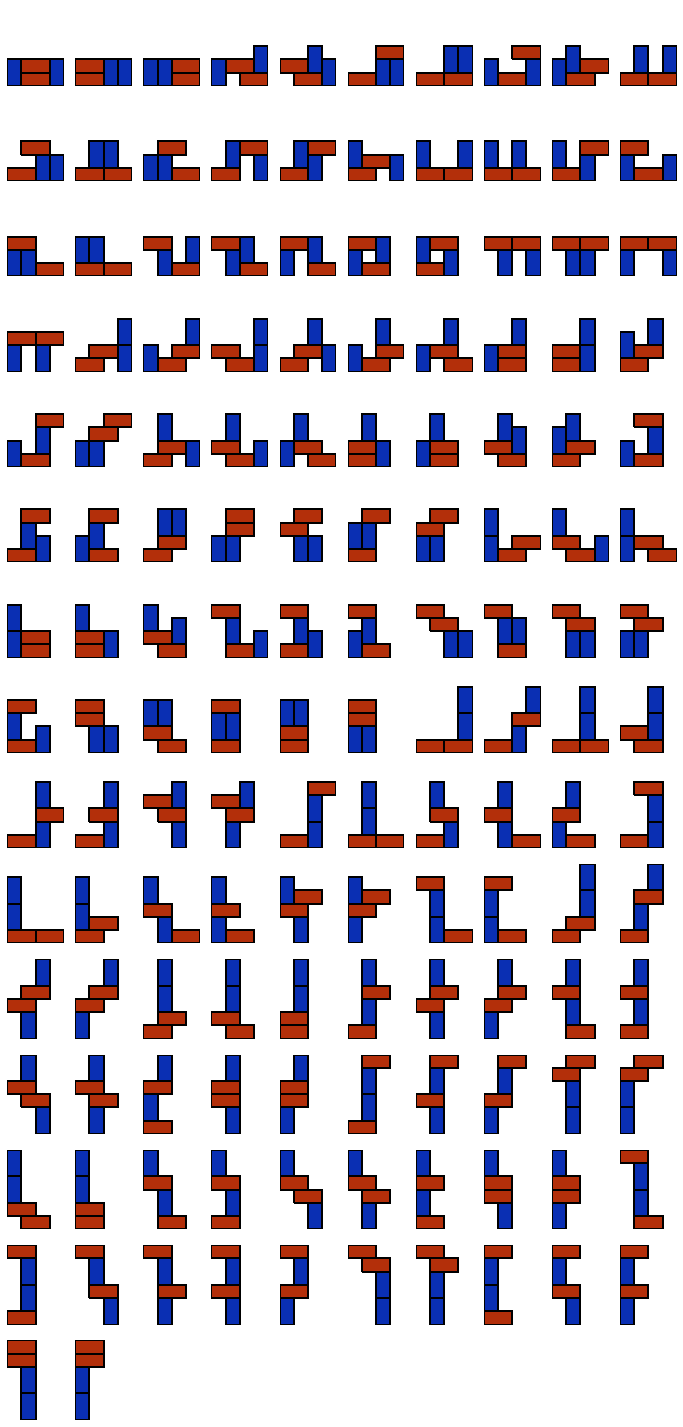

In [15]:
print('All 4-block towers that meet our contraints, before removing duplicate silhouettes')
utils.draw_towers([utils.worldify(w, 
                                  block_dims = block_dims, 
                                  block_colors = block_colors) 
                   for w in four_block_superset['stim']],
                 figsize=(12,26))

In [16]:
len(four_block_superset)

142

#### Silhouette Superset- contains one tower of each silhouette from the set above

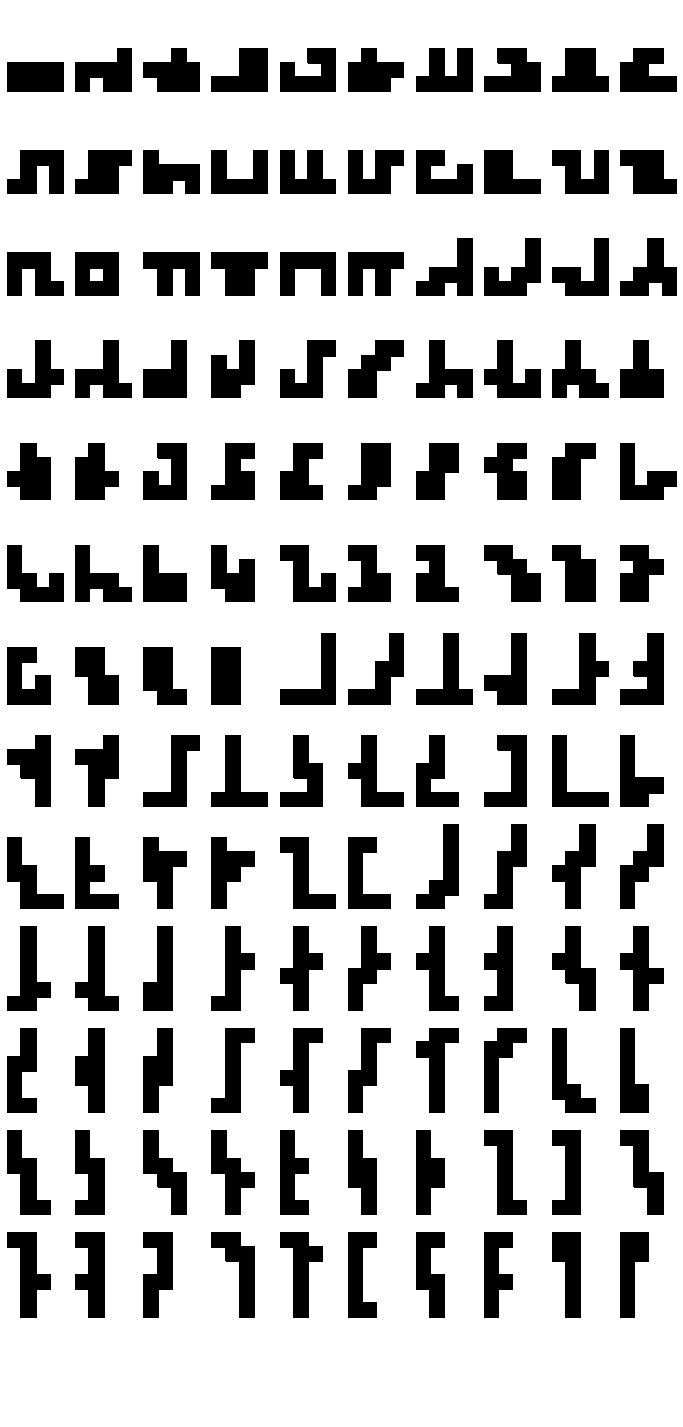

In [17]:
# set of silhouettes to be used in prior elicitation study
render = True

silhouette_superset = four_block_superset.groupby('silhouette_str').agg('first').reset_index()
silhouette_superset['tower_number'] = silhouette_superset.index
silhouette_superset['tower_number_str'] = silhouette_superset['tower_number'].apply(lambda x: str(x).zfill(3))
silhouette_superset['tower_name'] = 'tower_4_block_unique_silhouette_' + silhouette_superset['tower_number_str']

if render:
    utils.draw_towers([utils.worldify(w, 
                                      block_dims = block_dims, 
                                      block_colors = black) 
                       for w in silhouette_superset['stim']],
                     figsize=(12,26))

In [18]:
len(silhouette_superset)

130

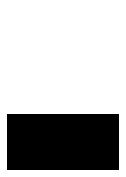

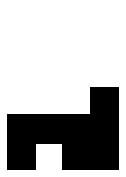

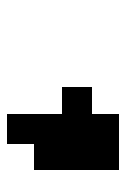

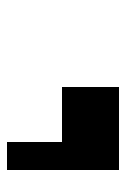

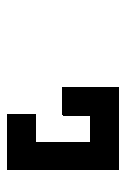

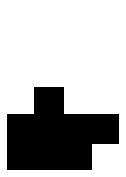

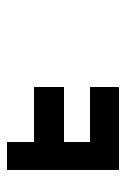

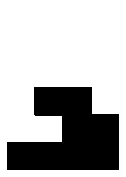

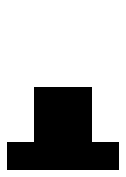

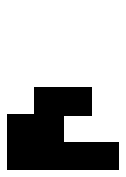

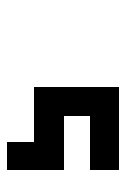

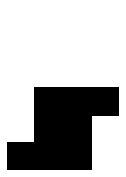

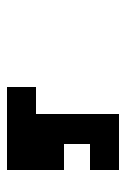

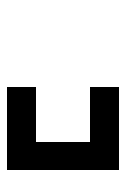

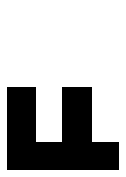

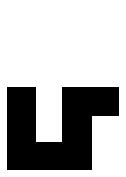

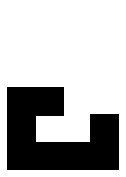

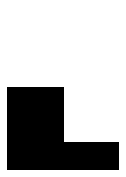

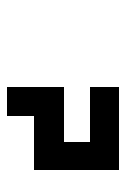

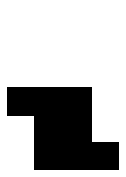

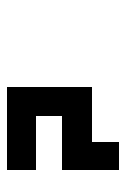

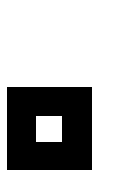

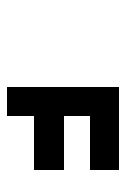

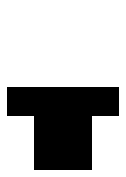

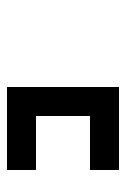

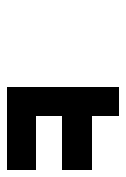

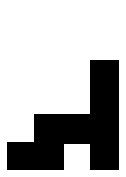

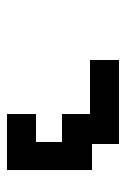

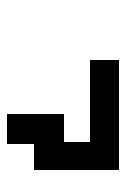

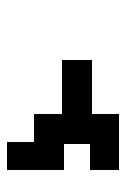

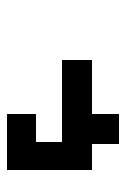

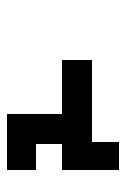

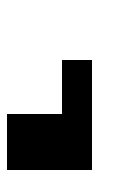

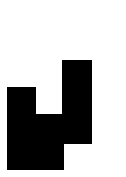

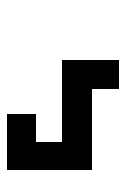

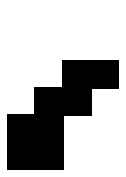

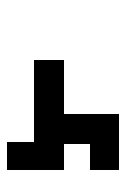

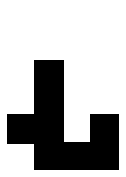

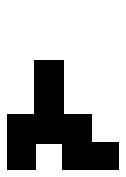

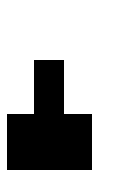

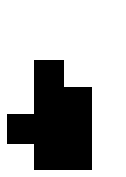

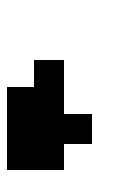

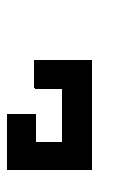

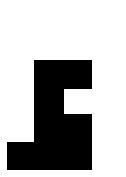

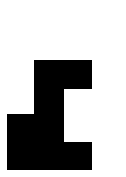

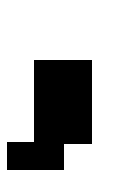

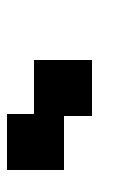

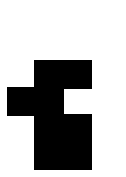

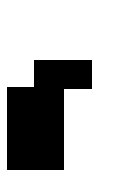

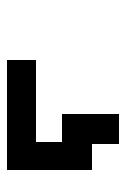

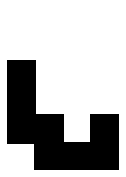

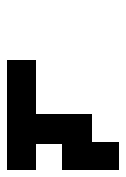

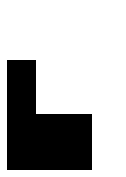

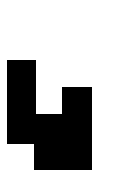

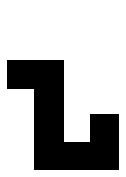

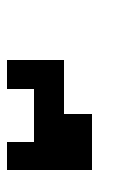

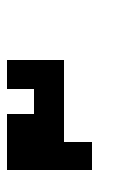

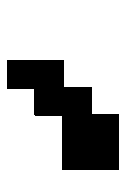

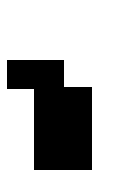

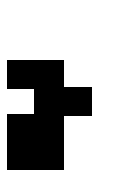

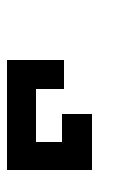

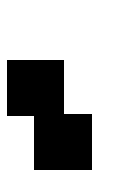

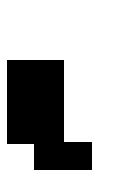

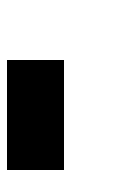

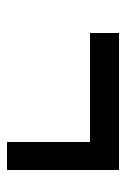

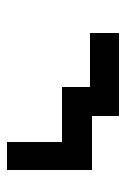

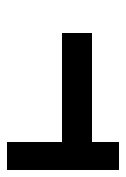

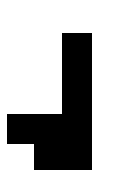

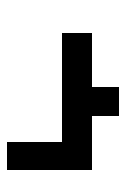

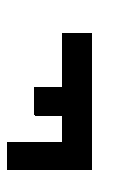

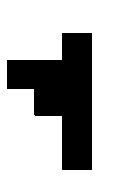

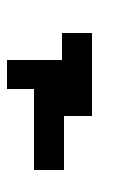

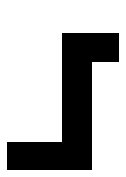

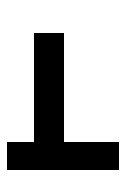

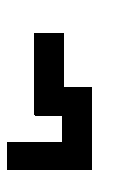

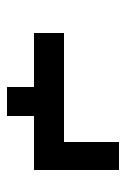

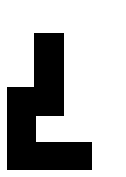

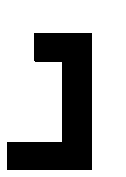

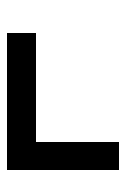

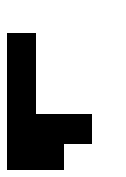

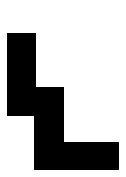

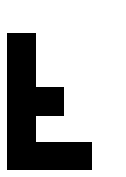

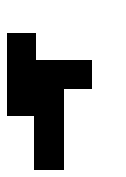

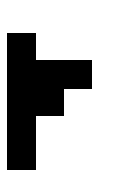

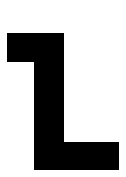

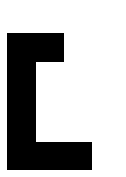

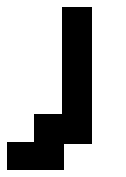

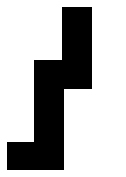

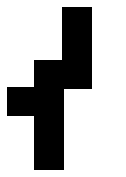

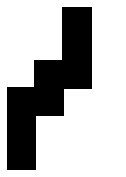

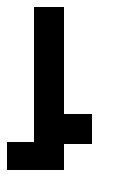

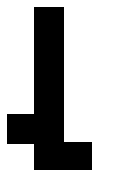

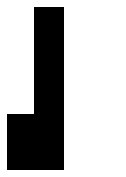

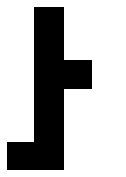

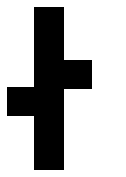

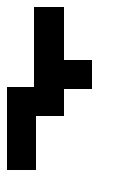

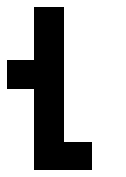

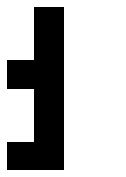

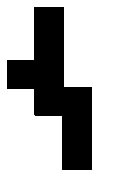

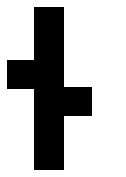

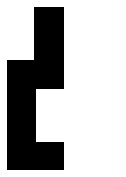

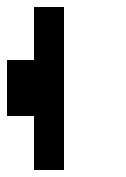

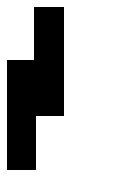

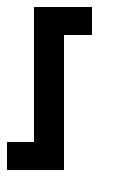

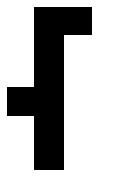

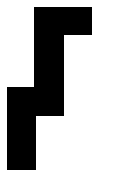

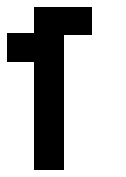

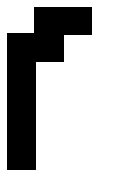

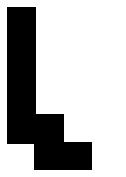

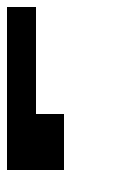

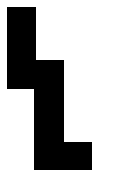

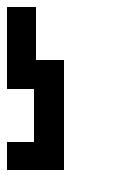

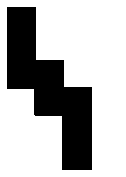

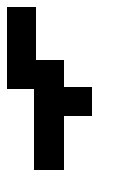

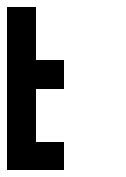

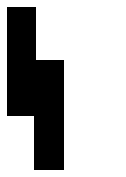

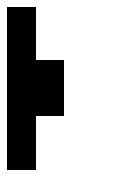

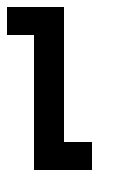

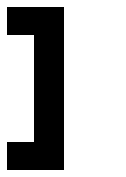

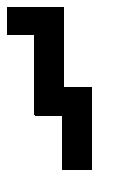

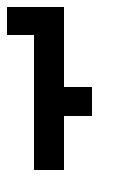

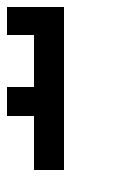

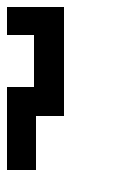

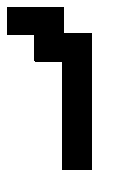

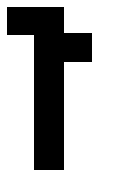

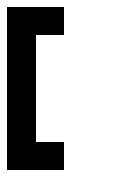

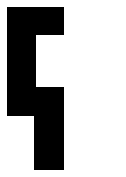

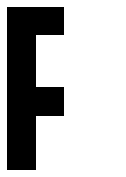

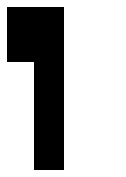

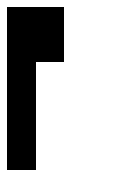

In [19]:
#save silhouettes pngs

tower_worlds = [utils.worldify(w,
                               block_dims = block_dims, 
                               block_colors = black)\
                    for w in silhouette_superset['stim']]

for i, w in enumerate(tower_worlds):
    fig = utils.draw_tower(w)
#     print(silhouette_superset.loc[i,'group'])
    #fig.savefig('./tower_4_block_unique_silhouettes/tower_4_block_unique_silhouette_'+str(i).zfill(3))

In [20]:
filepath ='./tower_4_block_unique_silhouettes_json/'

if not os.path.exists(filepath):
        os.makedirs(filepath)

for i, w in enumerate(tower_worlds):
    with open(os.path.join(filepath, 'tower_4_block_unique_silhouettes_{}.json'.format(str(i).zfill(3))), 'w') as fout:
#         json.dump(tower_worlds[i].get_block_dict(),fout)

SyntaxError: unexpected EOF while parsing (<ipython-input-20-f5a599f9fd6d>, line 8)

## Find tall and wide towers

We can apply different constraints to give different 'wide' and 'tall' subsets.



## Tightest constraints: Tall = width 2, Wide = width 4, height 3, 2+ off ground

These are designed to easily make composite towers from abutting tall towers and stacked wide towers

In [23]:
# label these subsets

silhouette_superset['group'] = 'neither'

silhouette_superset.loc[(silhouette_superset.tower_height == 3) &
                                    (silhouette_superset.tower_width == 4) &
                                    (silhouette_superset.blocks_above_ground >=2),'group'] = 'wide'


silhouette_superset.loc[(silhouette_superset.tower_height >= 5) &
                                  (silhouette_superset.tower_width == 2),'group'] = 'tall'

18 vertical towers


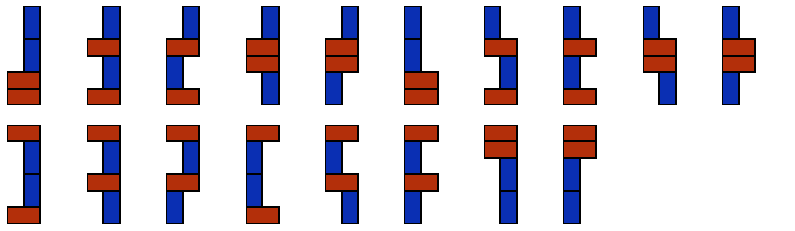

In [27]:
unique_by_silhoutte = True


# Tall subset (width 2 + other constraints above)
tall_subset_w2 = silhouette_superset[silhouette_superset.group == 'tall'].reset_index()

utils.draw_towers([utils.worldify(w, 
                                  block_dims = block_dims, 
#                                   block_colors = black,
                                  block_colors = block_colors,
                                 ) 
                   for w in tall_subset_w2['stim']],
                 figsize=(14,4))

print(str(len(tall_subset_w2))+ ' vertical towers')

18 horizontal towers with width 4


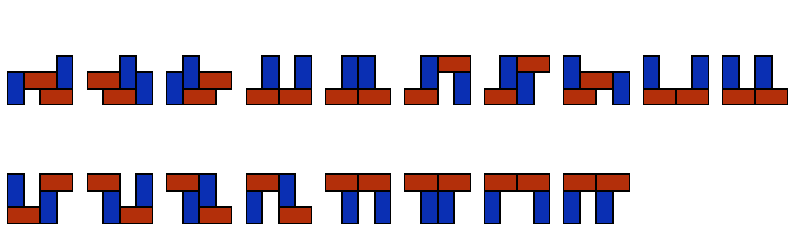

In [28]:
# Wide tower constraints

# Wide subset (width 2 + other constraints above)
wide_subset_w4 =silhouette_superset[silhouette_superset.group == 'wide'].reset_index()

utils.draw_towers([utils.worldify(w, 
                                  block_dims = block_dims, 
                                 #block_colors = black,
                                  block_colors = block_colors
                                 ) 
                   for w in wide_subset_w4['stim']],
                 figsize=(14,4))

print(str(len(wide_subset_w4))+ ' horizontal towers with width 4')

We get different sets if we use silhouette_superset and four_block_superset. Because silhouette_superset may filter out towers that meet constraints (i.e. have >=2 blocks off the ground). However, only two are filtered out, and they cannot be build from the vertical towers, so we leave these out.

In [73]:
# get numbers of towers in each set
wide_ids = list(wide_subset_w4['tower_number_str'])
tall_ids = list(tall_subset_w2['tower_number_str'])

#### Save tower data for use in prior elicitation study

In [50]:
# save dataframe for generating metadata for prior elicitation
# silhouette_superset.to_pickle("./tower_4_block_unique_silhouettes/tower_4_block_unique_silhouettes.pkl")

### Compose wide and tall towers

In [29]:
horz_composition_tall_subset_w2 = np.array([[compose_horizontally(stim_a, 
                                                                  stim_b,
                                                                  keep_separable=True)\
                             for stim_a in tall_subset_w2['stim']]\
                                 for stim_b in tall_subset_w2['stim']])

In [30]:
vert_composition_wide_subset_w4 = np.array([[compose_vertically(stim_a, stim_b)\
                             for stim_a in wide_subset_w4['stim']]\
                                 for stim_b in wide_subset_w4['stim']])

In [31]:
horz_maps_w2 = np.array(list(map(lambda x: utils.convert_to_str(x.block_map),
                  horz_composition_tall_subset_w2[:,:,1].flatten())))

vert_maps_w4 = np.array(list(map(lambda x: utils.convert_to_str(x.block_map),
                  vert_composition_wide_subset_w4[:,:,1].flatten())))

### Make composite dataframe

In [115]:
df_composites = pd.DataFrame()

# compose tall towers by pushing together
for i, tower_A in tall_subset_w2.iterrows():
    for j, tower_B in tall_subset_w2.iterrows():
        composite = compose_horizontally(tower_A['stim'], tower_B['stim'])
        if composite[0]: #check if successful composition
            df_composites = df_composites.append({
                'composite': composite[1], #world
                #'offset': composite[2], # no offset for vertical stacks
                'block_map': composite[1].block_map,
                'block_dict': composite[1].get_block_dict()['blocks'],
                'block_str': utils.convert_to_str(composite[1].block_map),
                'tower_A_dict': tower_A['stim'],
                'tower_B_dict': tower_B['stim'],
                'tower_A_number_str': tower_A['tower_number_str'], # left
                'tower_B_number_str': tower_B['tower_number_str'], # right
                'tower_A_position':'left',
                'tower_B_position':'right',
                'tower_type': 'talls',
                'tower_id': 'talls_' + tower_A['tower_number_str'] + '_' + tower_B['tower_number_str'],
                'ambiguous': utils.convert_to_str(composite[1].block_map) in vert_maps_w4
            }, ignore_index=True)

# compose wide towers by stacking            
for i, tower_A in wide_subset_w4.iterrows():
    for j, tower_B in wide_subset_w4.iterrows():
        composite = compose_vertically(tower_A['stim'], tower_B['stim'])
        
        if composite[0]: #check if successful composition
            df_composites = df_composites.append({
                'composite': composite[1], #world
                #'offset': composite[2], # no offset for vertical stacks
                'block_map': composite[1].block_map,
                'block_dict': composite[1].get_block_dict()['blocks'],
                'block_str': utils.convert_to_str(composite[1].block_map),
                'tower_A_dict': tower_A['stim'],
                'tower_B_dict': tower_B['stim'],
                'tower_A_number_str': tower_A['tower_number_str'], # bottom
                'tower_B_number_str': tower_B['tower_number_str'], # top
                'tower_A_position':'bottom',
                'tower_B_position':'top',
                'tower_type': 'wides',
                'tower_id': 'wides_' + tower_A['tower_number_str'] + '_' + tower_B['tower_number_str'],
                'ambiguous': utils.convert_to_str(composite[1].block_map) in horz_maps_w2
            }, ignore_index=True)

In [116]:
df_composites

,ambiguous,block_dict,block_map,block_str,composite,tower_A_dict,tower_A_number_str,tower_A_position,tower_B_dict,tower_B_number_str,tower_B_position,tower_id,tower_type
0,0.0,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000010100000101000001010000010100...,<blockworld_helpers.World object at 0x7fa05747...,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...",092,left,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...",092,right,talls_092_092,talls
1,0.0,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000010100000101000001110000010100...,<blockworld_helpers.World object at 0x7fa056be...,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...",092,left,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...",097,right,talls_092_097,talls
2,0.0,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000010100000101000001110000011000...,<blockworld_helpers.World object at 0x7fa05770...,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...",092,left,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...",100,right,talls_092_100,talls
3,0.0,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000010100000101000001110000011100...,<blockworld_helpers.World object at 0x7fa05752...,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...",092,left,"[{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...",101,right,talls_092_101,talls
4,0.0,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000010100000101000001110000011100...,<blockworld_helpers.World object at 0x7fa065d4...,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...",092,left,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...",102,right,talls_092_102,talls
...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,1.0,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000111000001010000010110000111100...,<blockworld_helpers.World object at 0x7fa05ed7...,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...",025,bottom,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...",020,top,wides_025_020,wides
510,1.0,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000111100000101000001010000111100...,<blockworld_helpers.World object at 0x7fa05ed6...,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...",025,bottom,"[{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...",022,top,wides_025_022,wides
511,1.0,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000111100000110000001100000111100...,<blockworld_helpers.World object at 0x7fa05ed6...,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...",025,bottom,"[{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...",023,top,wides_025_023,wides
512,1.0,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000111100001001000010010000111100...,<blockworld_helpers.World object at 0x7fa05ed6...,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...",025,bottom,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...",024,top,wides_025_024,wides


#### Save composite towers locally

In [110]:
# df_composites.to_pickle("./tower_4_block_unique_silhouettes_composites/tower_4_block_unique_silhouettes_composites.pkl")


In [119]:
# Save towers locally for upload to S3

filepath ='./tower_4_block_unique_silhouettes_composites_json/'

for i, composite_row in df_composites.iterrows():
    #fig = utils.draw_tower(composite_row['composite']) # draw composite tower
    with open(os.path.join(filepath, 'tower_4_block_unique_silhouettes_composite_{}.json'\
                               .format(str(composite_row['tower_id']))), 'w') as fout:
#         json.dump(composite_row['composite'].get_block_dict(),fout)
    

In [106]:
! git push

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 8 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 37.25 KiB | 1.86 MiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
remote: This repository moved. Please use the new location:
remote:   https://github.com/cogtoolslab/compositional-abstractions.git
To https://github.com/hawkrobe/compositional-abstractions.git
   6aab4d0..17beaae  master -> master


In [97]:
# overlap
print(sum(df_composites[df_composites.tower_type=='wides']['ambiguous']))
print(sum(df_composites[df_composites.tower_type=='talls']['ambiguous']))

152.0
152.0


Colored composites are ambiguous, i.e. can be made by combining two wide towers


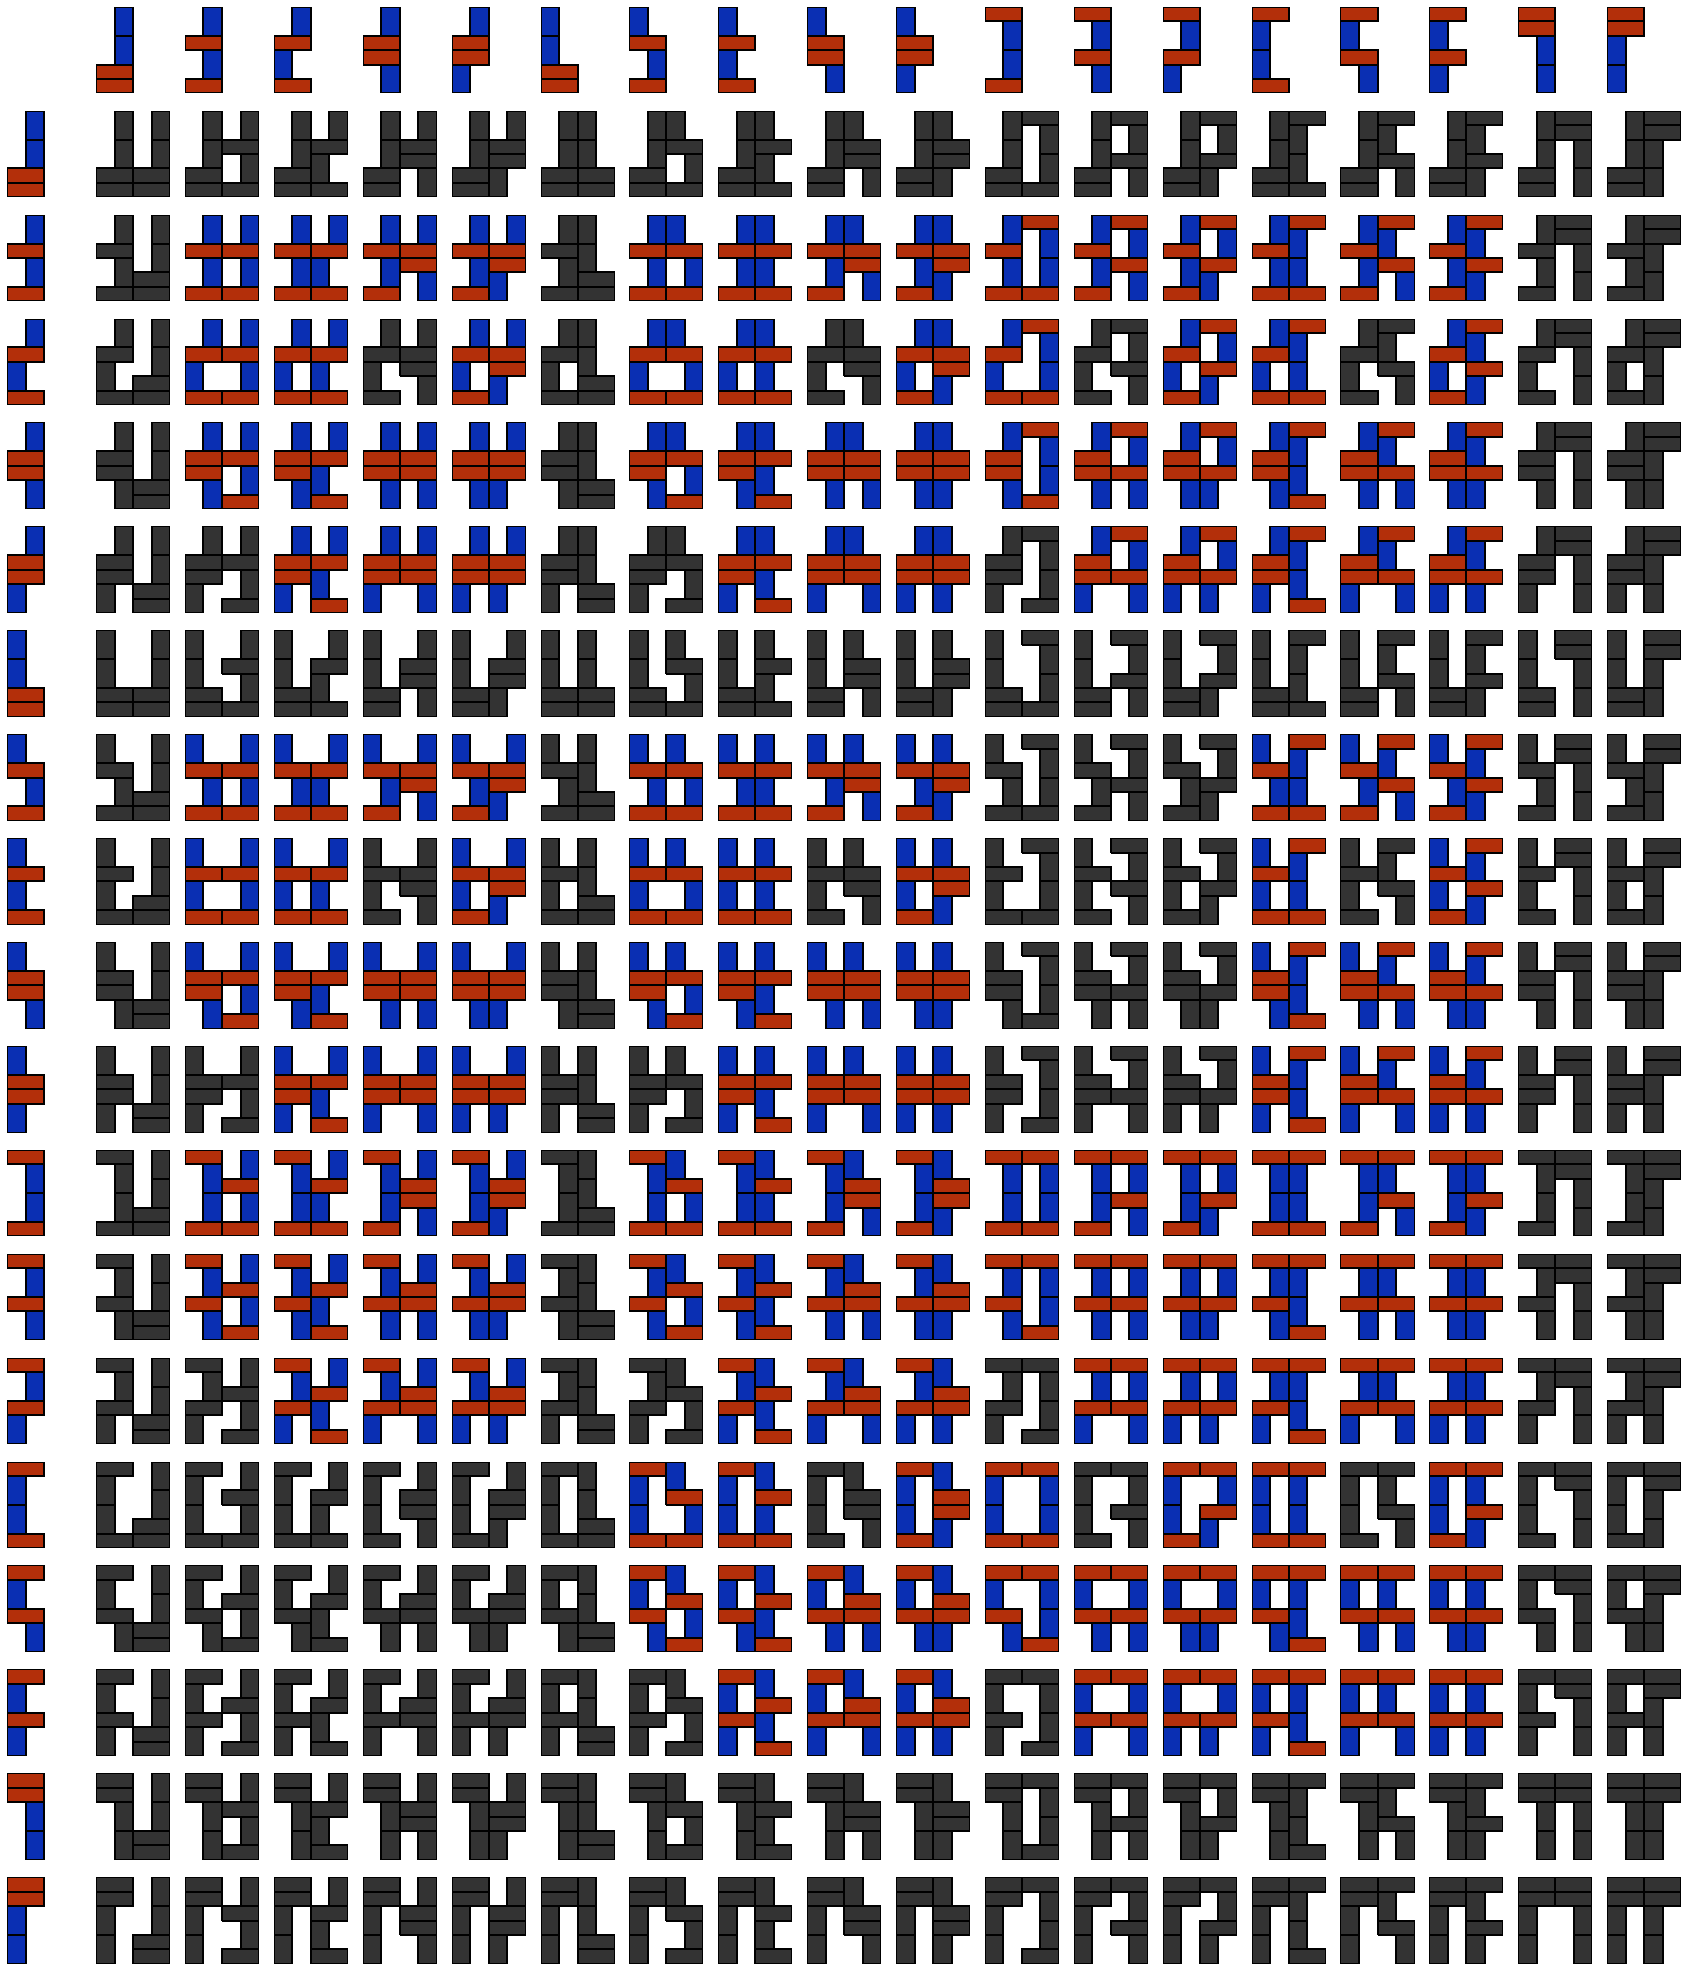

In [94]:
n_towers = len(tall_ids)

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 36) )

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    world = utils.worldify(tall_subset_w2['stim'][i], 
                           block_dims = block_dims, 
                           block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
# iterate over towers
for i, A_id in enumerate(tall_ids):
    for j, B_id in enumerate(tall_ids):
        maybe_composite =  df_composites[(df_composites.tower_type == 'talls') & # redundant but in for clarity
                                         (df_composites.tower_A_number_str == A_id) &
                                         (df_composites.tower_B_number_str == B_id)].reset_index()
        
        if len(maybe_composite) == 1:
            world = maybe_composite['composite'][0]
            if maybe_composite['ambiguous'][0]:
                utils.tower_subplot(utils.patches_for_world(world.blocks), 
                                axs[i+1,j+1])
                
            else:
                world_grey = utils.worldify(world.get_block_dict()['blocks'],
                                       block_dims = block_dims, 
                                       block_colors = grey)
                utils.tower_subplot(utils.patches_for_world(world_grey.blocks), 
                                axs[i+1,j+1])
                
print('Colored composites are ambiguous, i.e. can be made by combining two wide towers')

Colored composites are ambiguous, i.e. can be made by combining two tall towers


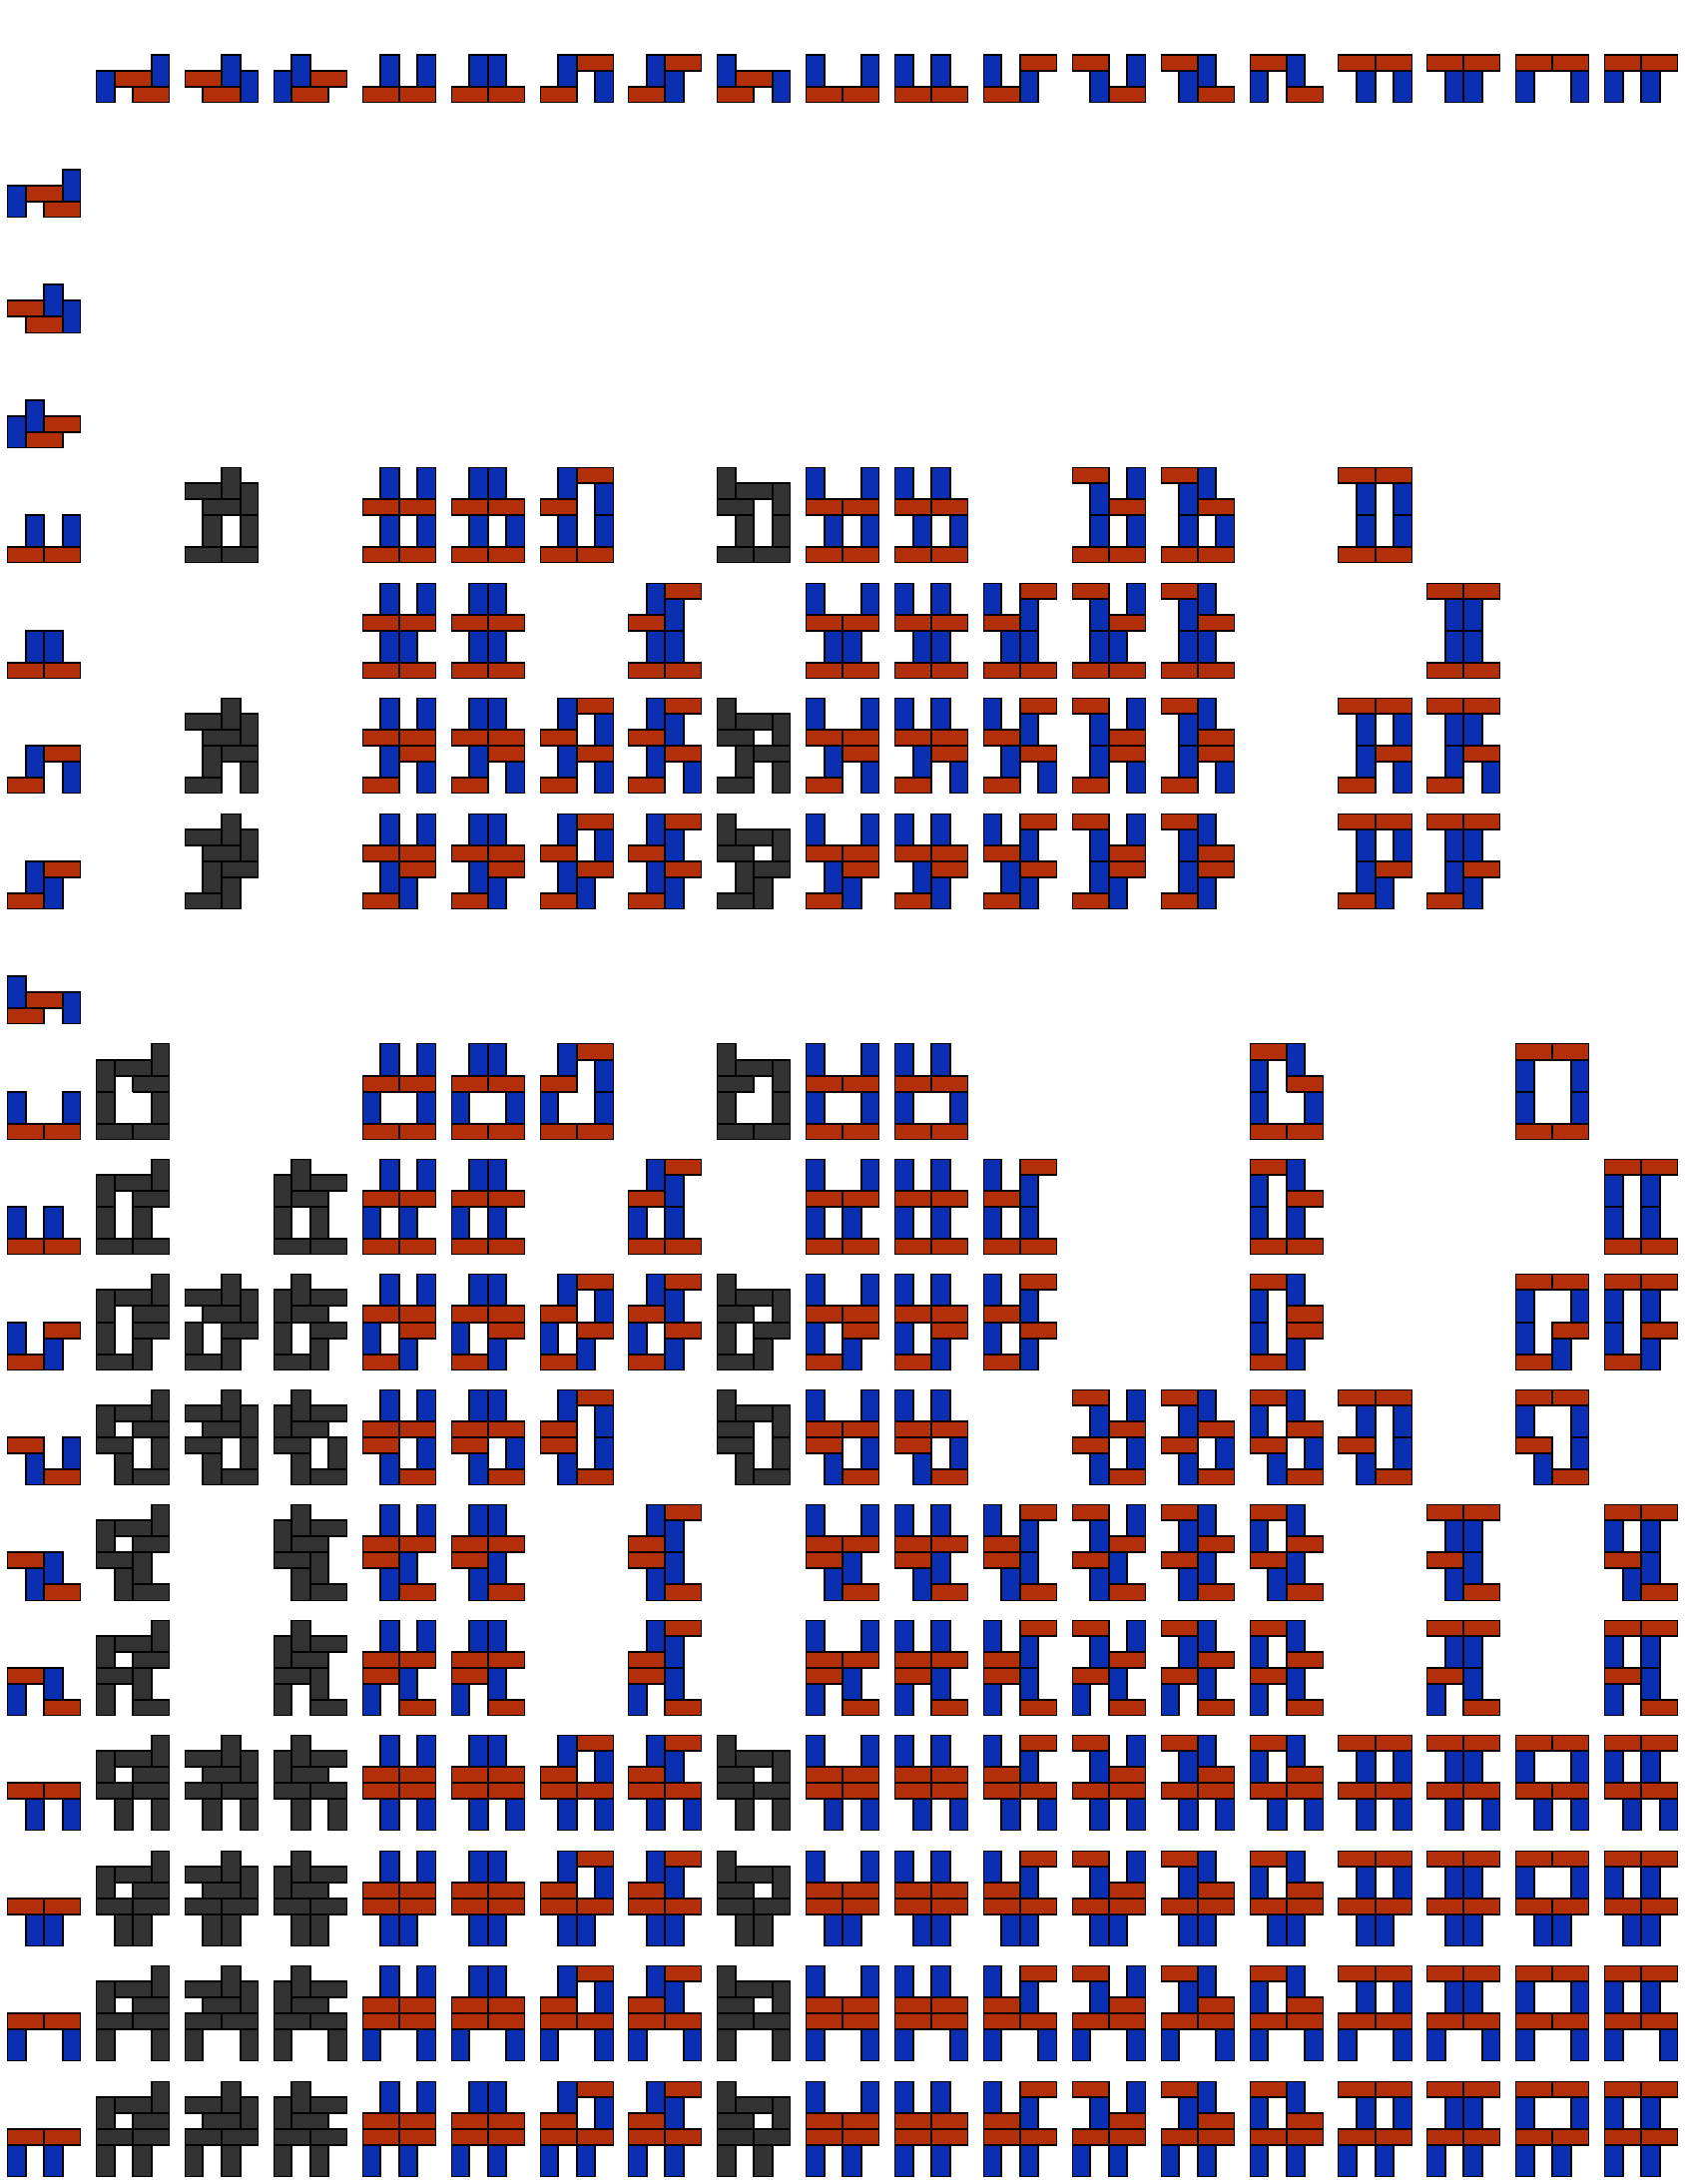

In [95]:
n_towers = len(tall_ids)

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 40) )

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    world = utils.worldify(wide_subset_w4['stim'][i], 
                           block_dims = block_dims, 
                           block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
# iterate over towers
for i, A_id in enumerate(wide_ids):
    for j, B_id in enumerate(wide_ids):
        maybe_composite =  df_composites[(df_composites.tower_type == 'wides') & # redundant but in for clarity
                                         (df_composites.tower_A_number_str == A_id) &
                                         (df_composites.tower_B_number_str == B_id)].reset_index()
        
        if len(maybe_composite) == 1:
            world = maybe_composite['composite'][0]
            if maybe_composite['ambiguous'][0]:
                utils.tower_subplot(utils.patches_for_world(world.blocks), 
                                axs[i+1,j+1])
                
            else:
                world_grey = utils.worldify(world.get_block_dict()['blocks'],
                                       block_dims = block_dims, 
                                       block_colors = grey)
                utils.tower_subplot(utils.patches_for_world(world_grey.blocks), 
                                axs[i+1,j+1])
                
print('Colored composites are ambiguous, i.e. can be made by combining two tall towers')

### Here onwards not used in experiments

In [87]:
! git push

Enumerating objects: 14, done.
Counting objects: 100% (14/14), done.
Delta compression using up to 8 threads
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 488.73 KiB | 8.57 MiB/s, done.
Total 8 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
remote: This repository moved. Please use the new location:
remote:   https://github.com/cogtoolslab/compositional-abstractions.git
To https://github.com/hawkrobe/compositional-abstractions.git
   7d9b703..6aab4d0  master -> master


152 tall-tower combos overlap with wides
Colored composites are ambiguous, i.e. can be made by combining two wide towers


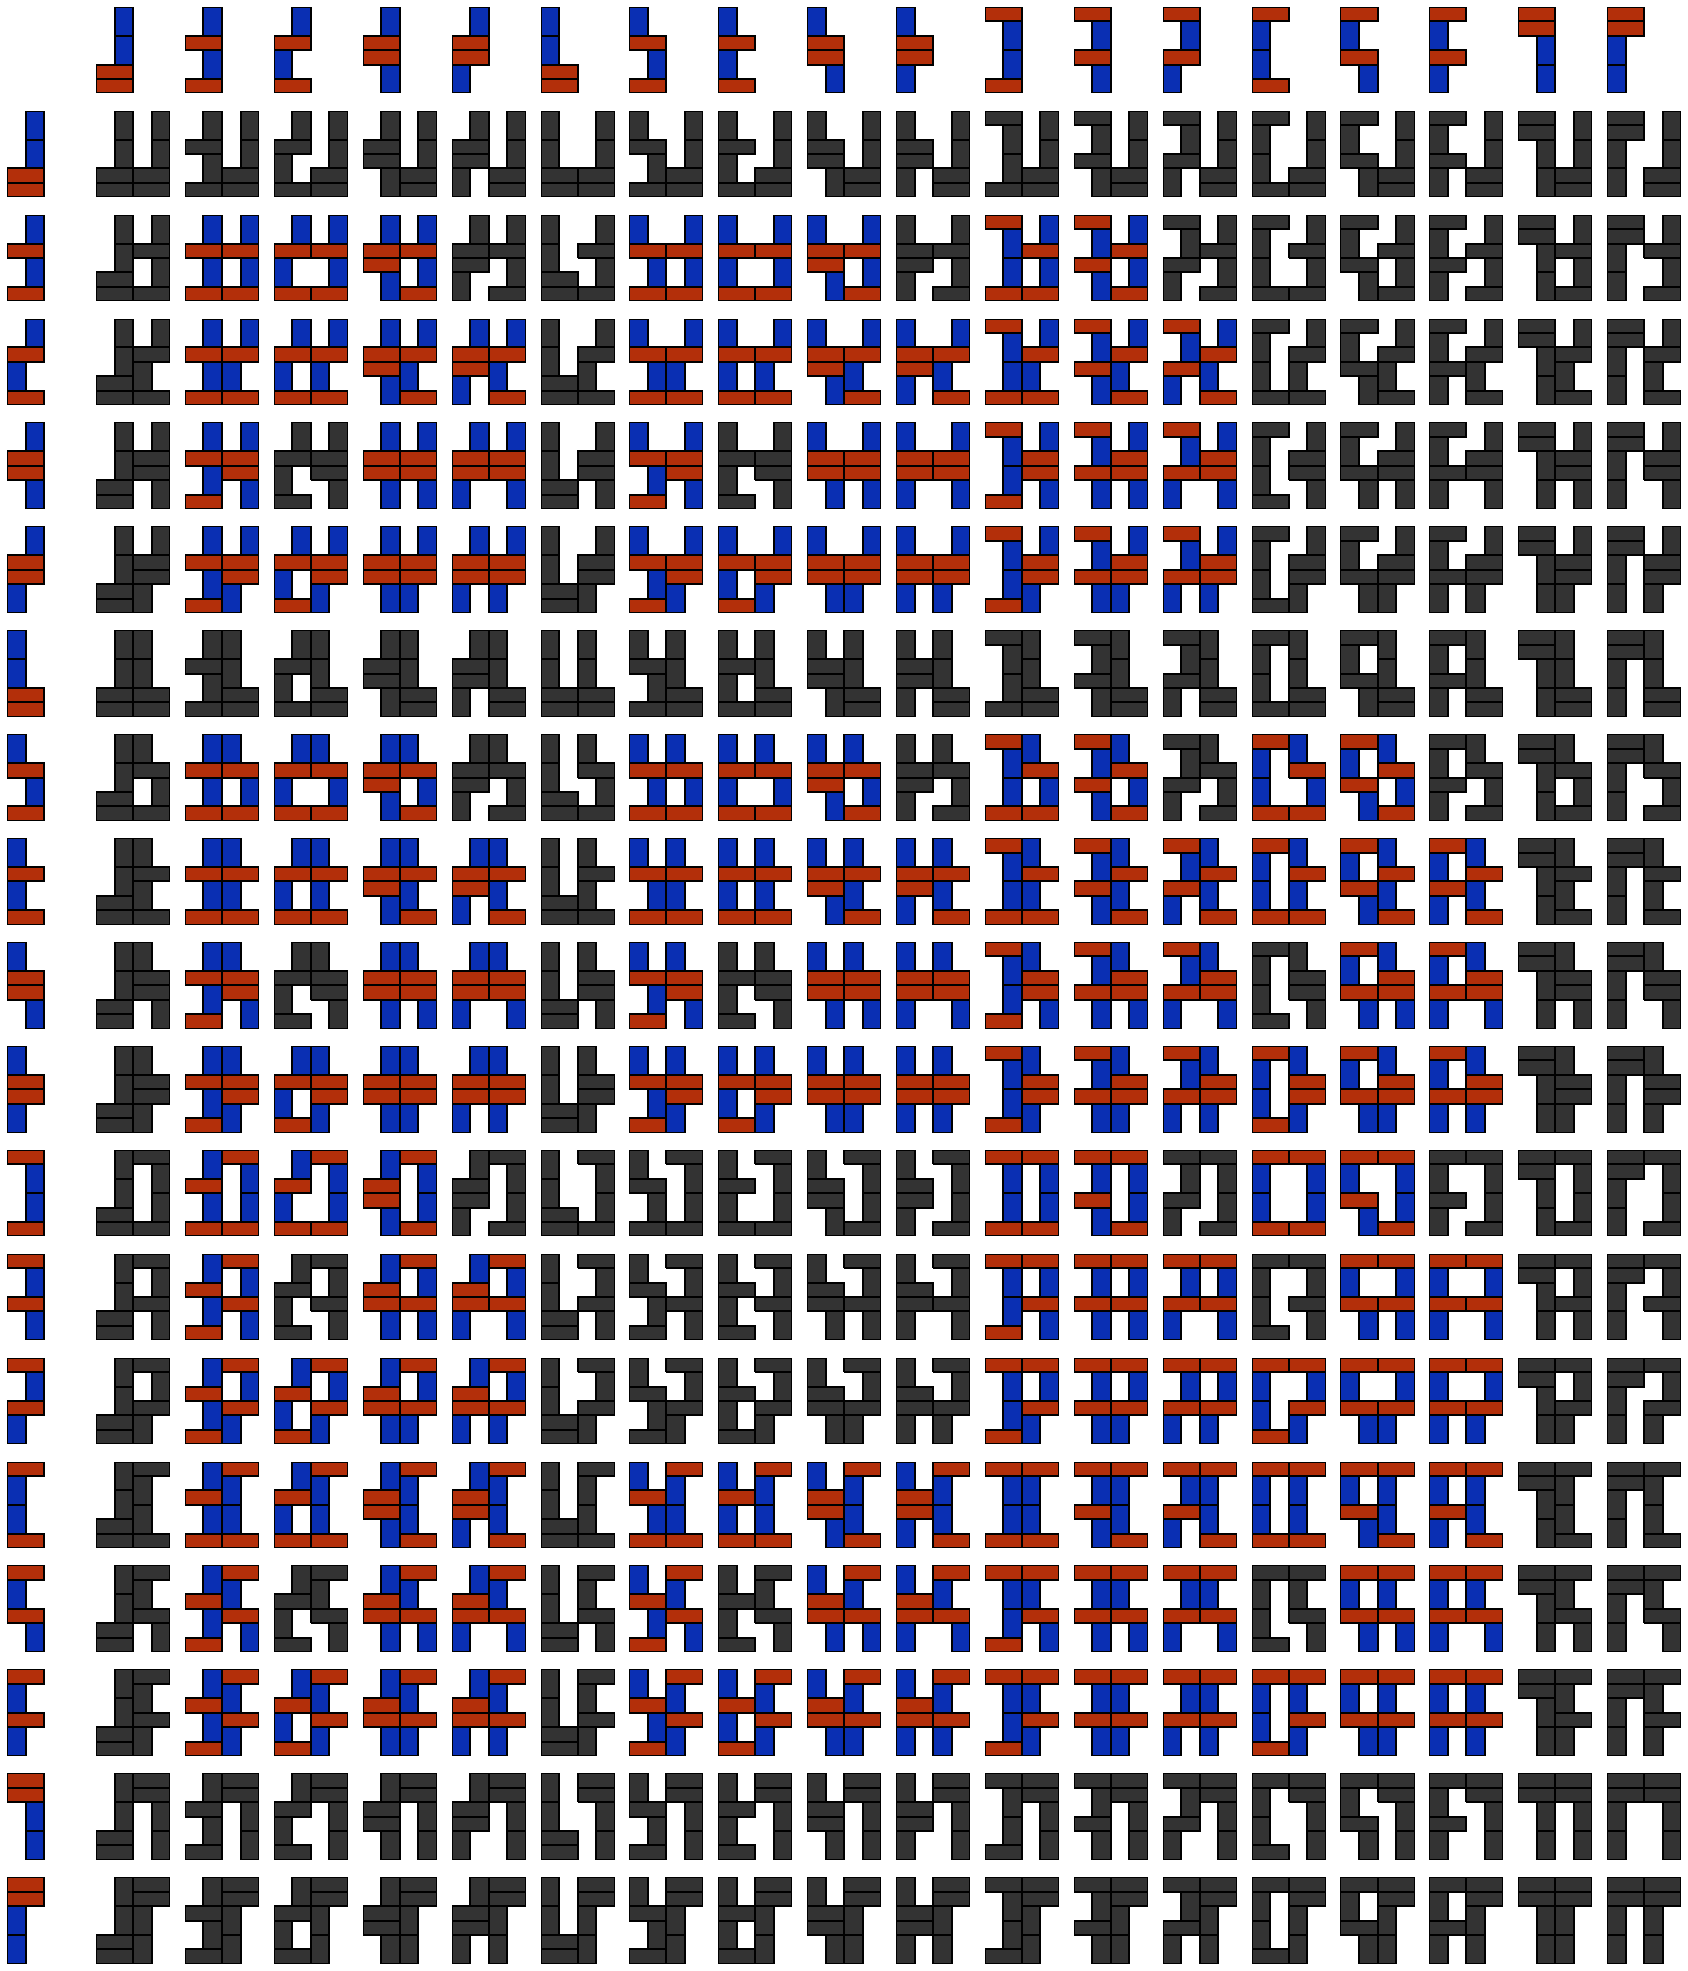

In [32]:
n_towers = horz_composition_tall_subset_w2.shape[0]

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 36) )

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    world = utils.worldify(tall_subset_w2['stim'][i], 
                           block_dims = block_dims, 
                           block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
tower_overlap = 0
    
# iterate over towers
for i in range(0, n_towers):
    for j in range(0, n_towers):
        if horz_composition_tall_subset_w2[i,j,0]:
            world = horz_composition_tall_subset_w2[i,j,1]
            if utils.convert_to_str(world.block_map) in vert_maps_w4:
                utils.tower_subplot(utils.patches_for_world(world.blocks), 
                                axs[i+1,j+1])
                tower_overlap = tower_overlap + 1
                
            else:
                world_grey = utils.worldify(world.get_block_dict()['blocks'],
                                       block_dims = block_dims, 
                                       block_colors = grey)
                utils.tower_subplot(utils.patches_for_world(world_grey.blocks), 
                                axs[i+1,j+1])
                
print(str(tower_overlap) + ' tall-tower combos overlap with wides')
print('Colored composites are ambiguous, i.e. can be made by combining two wide towers')

152 wide-tower combos overlap with talls
Colored composites are ambiguous, i.e. can be made by combining two tall towers


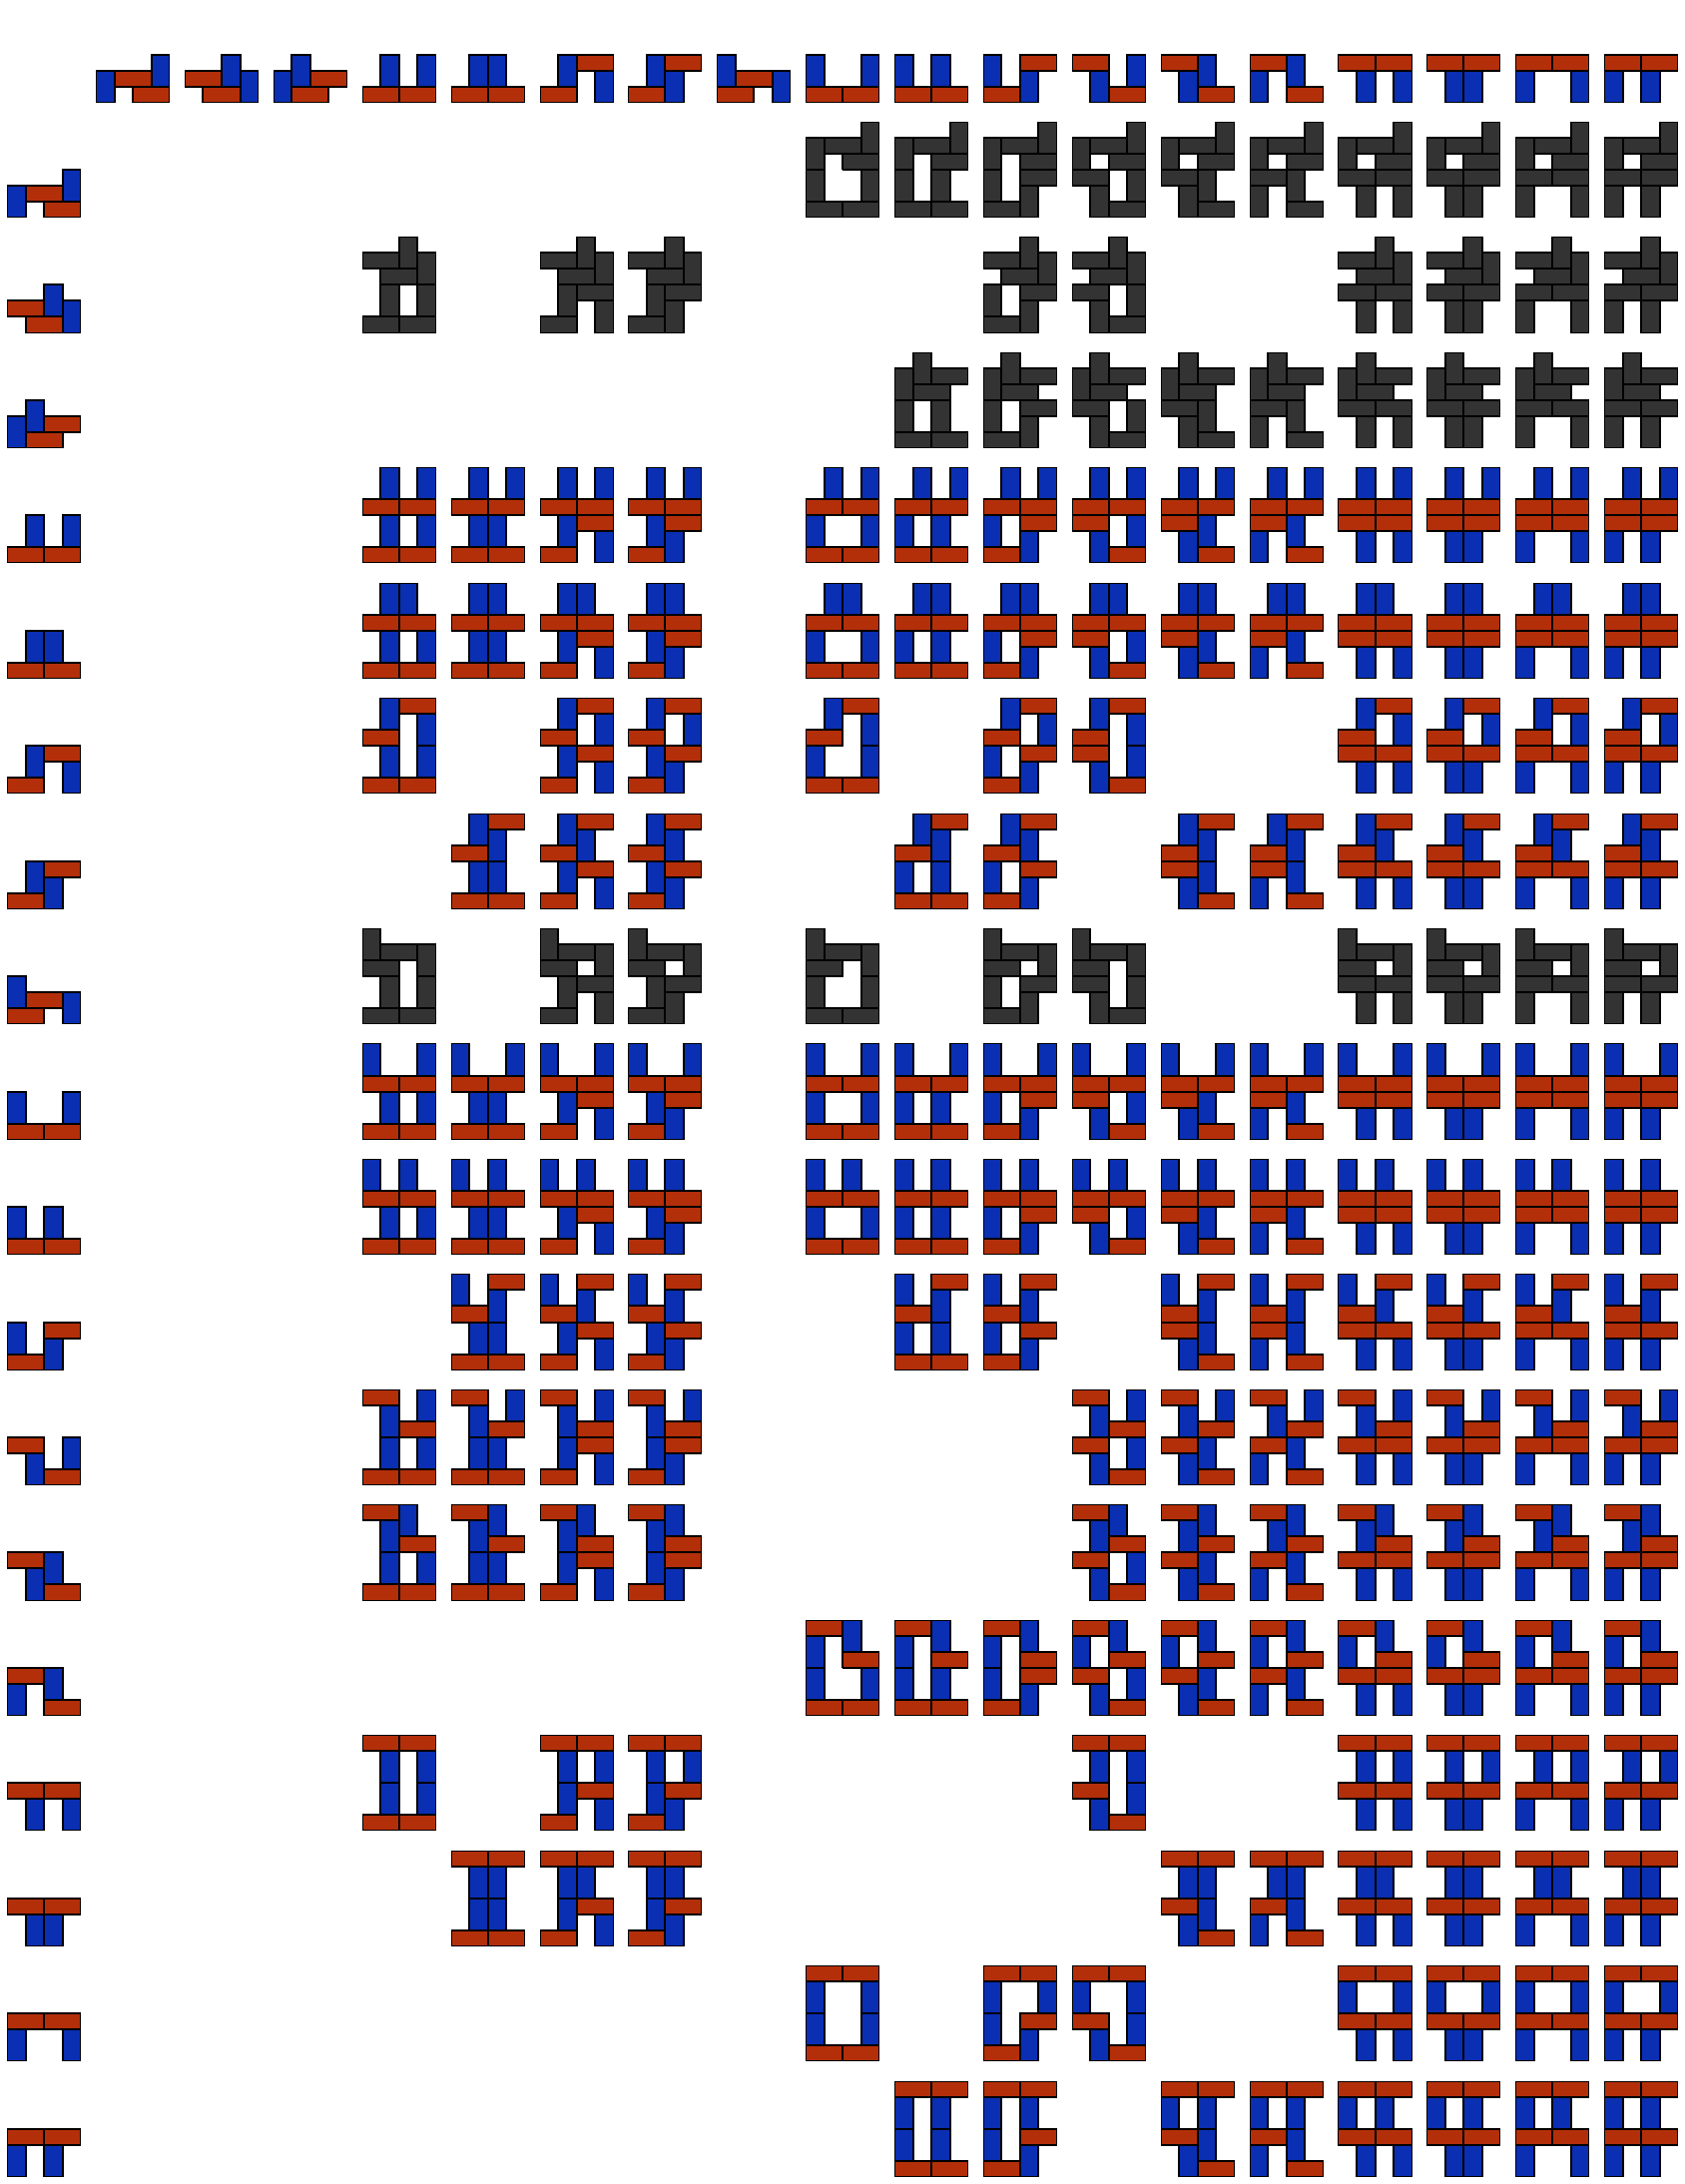

In [33]:
n_towers = vert_composition_wide_subset_w4.shape[0]

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 40))

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    #grab tower
    world = utils.worldify(wide_subset_w4['stim'][i], 
                           block_dims = block_dims, 
                           block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])

tower_overlap = 0

# iterate over towers
for i in range(0, n_towers):
    for j in range(0, n_towers):
        if vert_composition_wide_subset_w4[i,j,0]:
            world = vert_composition_wide_subset_w4[i,j,1]
            if utils.convert_to_str(world.block_map) in horz_maps_w2:
                utils.tower_subplot(utils.patches_for_world(world.blocks), 
                                axs[i+1,j+1])
                tower_overlap = tower_overlap + 1
                
            else:
                world_grey = utils.worldify(world.get_block_dict()['blocks'],
                                       block_dims = block_dims, 
                                       block_colors = grey)
                utils.tower_subplot(utils.patches_for_world(world_grey.blocks), 
                                axs[i+1,j+1])
                
print(str(tower_overlap) + ' wide-tower combos overlap with talls')
print('Colored composites are ambiguous, i.e. can be made by combining two tall towers')

152 tall-tower combos overlap with wides


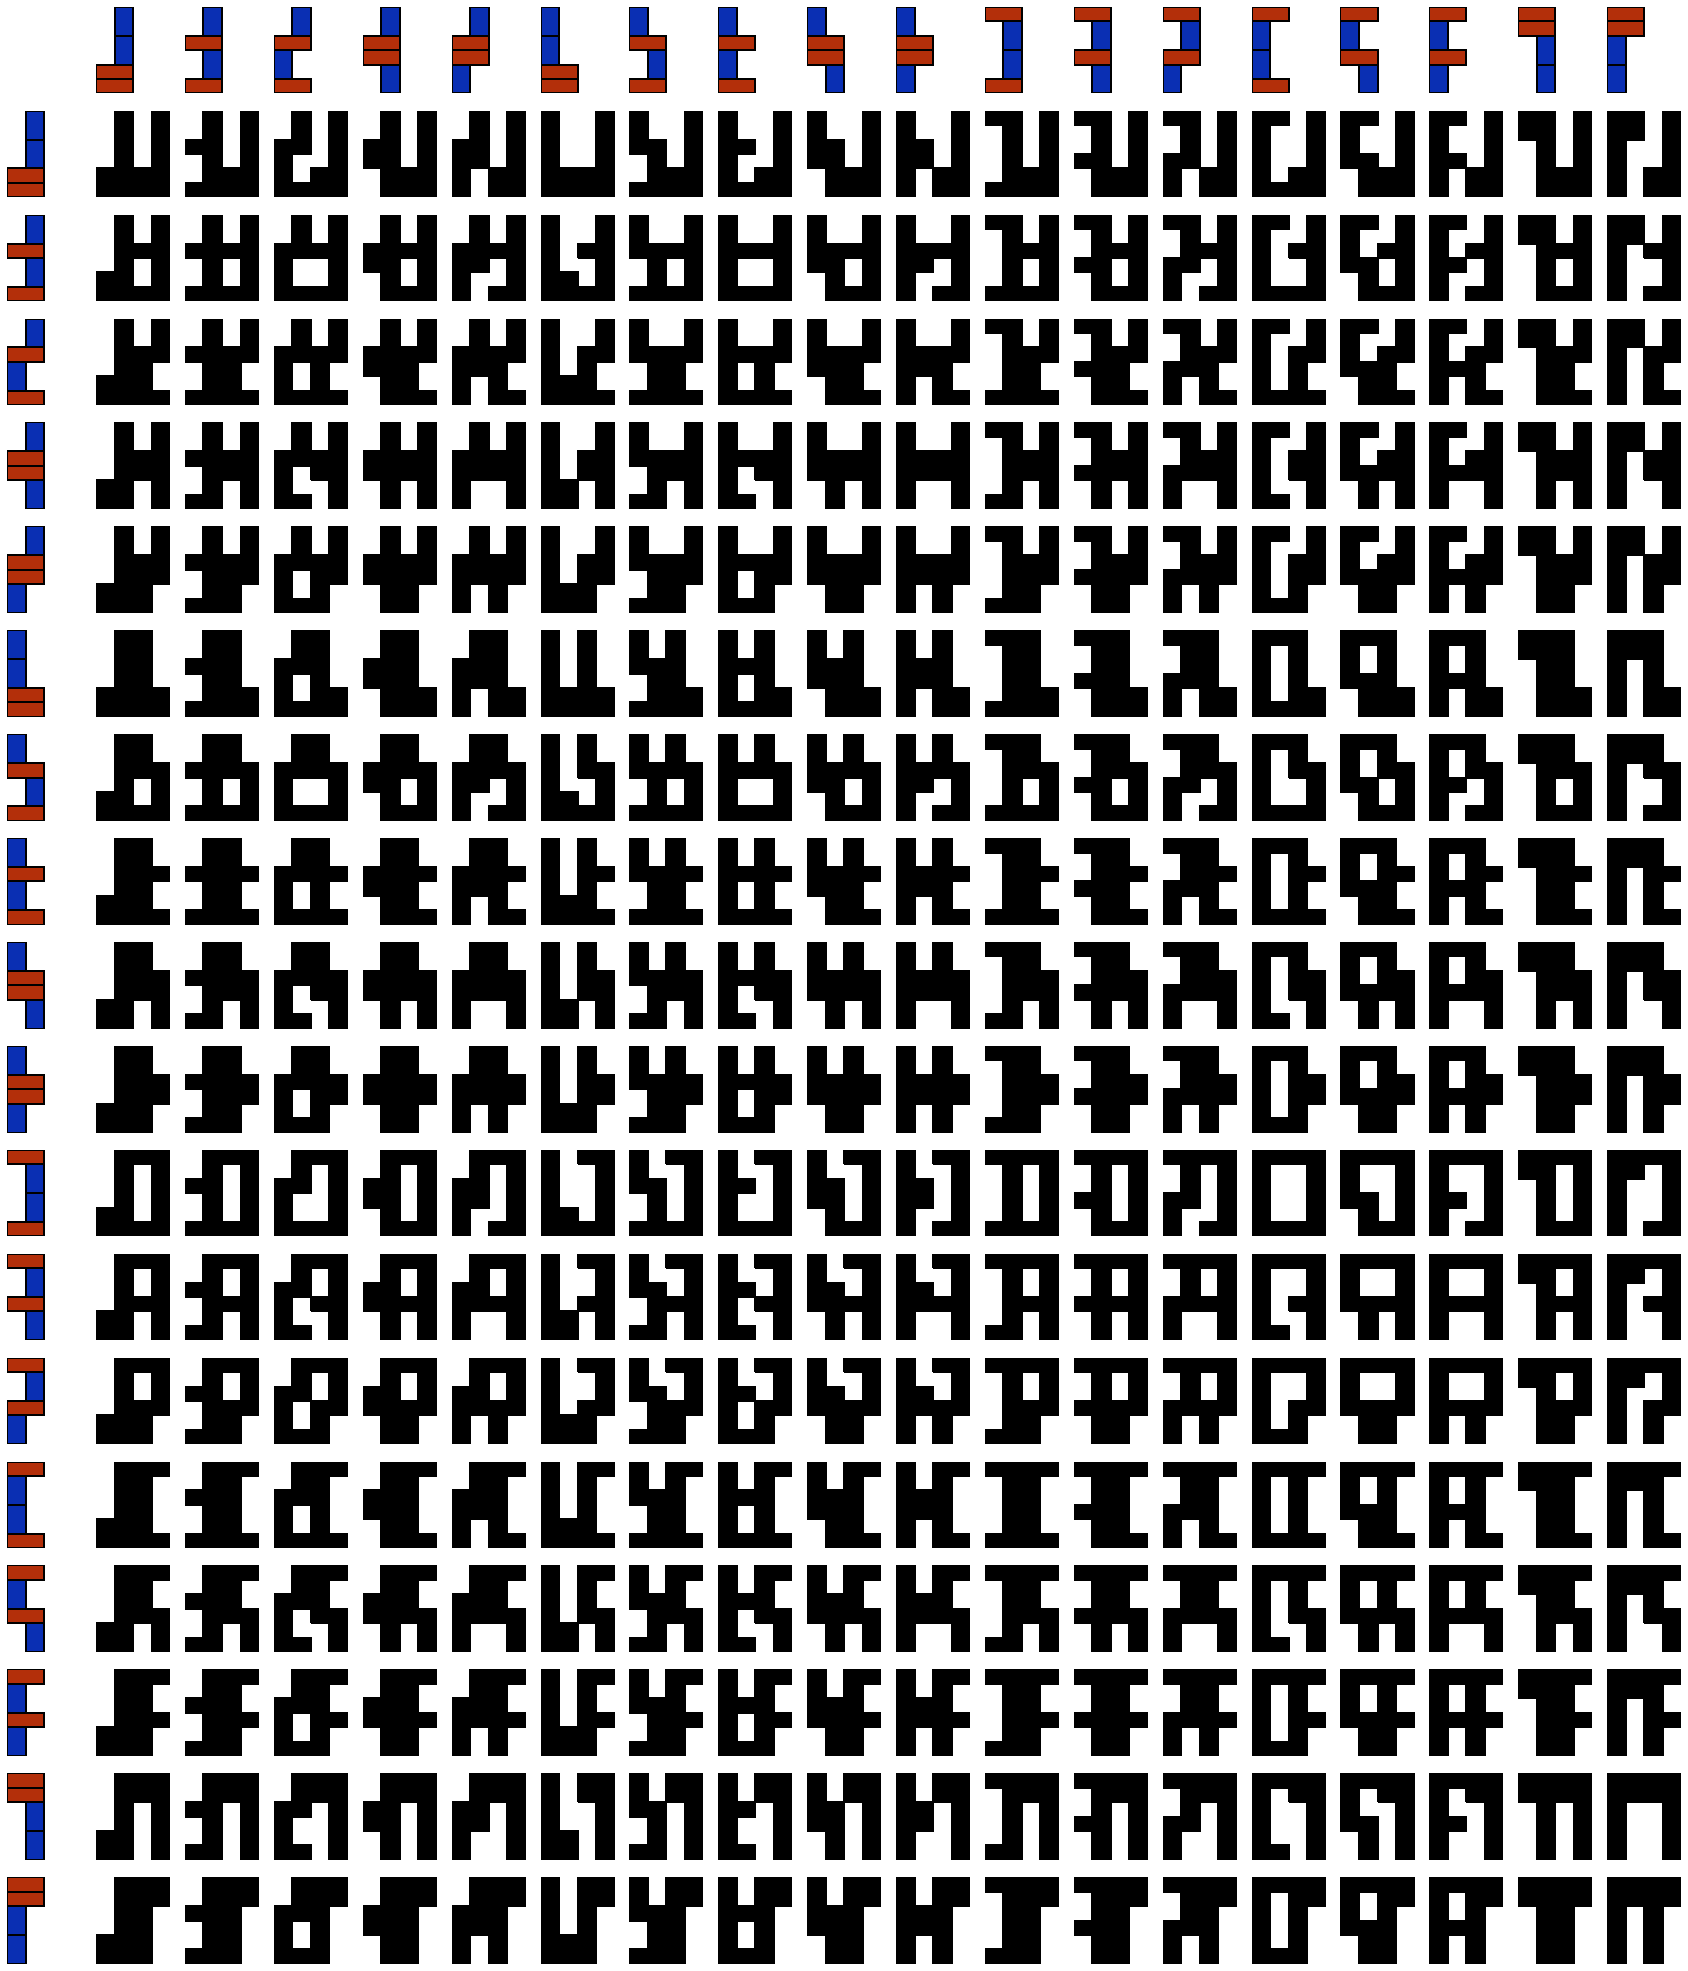

In [26]:
# Display as silhouettes

n_towers = horz_composition_tall_subset_w2.shape[0]

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 36) )

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    world = utils.worldify(tall_subset_w2['stim'][i], 
                           block_dims = block_dims, 
                           block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
tower_overlap = 0
    
# iterate over towers
for i in range(0, n_towers):
    for j in range(0, n_towers):
        if horz_composition_tall_subset_w2[i,j,0]:
            world = horz_composition_tall_subset_w2[i,j,1]
            world_black = utils.worldify(world.get_block_dict()['blocks'],
                                       block_dims = block_dims, 
                                       block_colors = black)
            if utils.convert_to_str(world.block_map) in vert_maps_w4:
                utils.tower_subplot(utils.patches_for_world(world_black.blocks), 
                                axs[i+1,j+1])
                tower_overlap = tower_overlap + 1
                
            else:
#                 world_grey = utils.worldify(world.get_block_dict()['blocks'],
#                                        block_dims = block_dims, 
#                                        block_colors = black)
                utils.tower_subplot(utils.patches_for_world(world_black.blocks), 
                                axs[i+1,j+1])
                
print(str(tower_overlap) + ' tall-tower combos overlap with wides')

# EXPLORATION: towers beneath here not used for an experiment

From here, we explore looser constraints.

First find maximal subsets, i.e.

Wide:
- height <=3

Tall:
- height >= 5
- width <= 5

These settings exclude e.g. 'L' used in previous study.

In [15]:
silhouette_superset['tower_type'] = 'neither'

silhouette_superset.loc[(silhouette_superset.tower_height <= 3),'tower_type'] = 'wide'

silhouette_superset.loc[((silhouette_superset.tower_height >= 5) &
                        (silhouette_superset.tower_width <= 3)), 'tower_type'] = 'tall'

26 horizontal towers


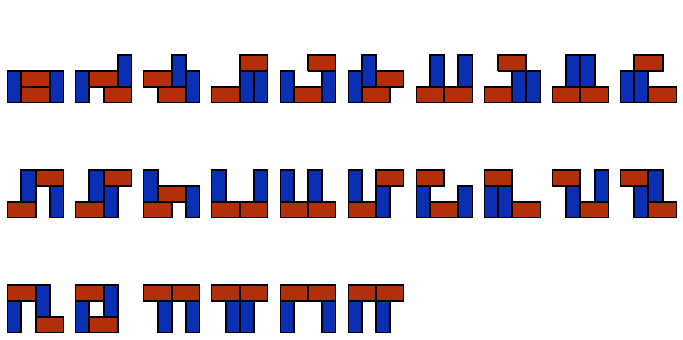

In [16]:
# Wide tower constraints

# wide_subset = four_block_superset[(four_block_superset.tower_height <= 3)].reset_index()
wide_subset = silhouette_superset[(silhouette_superset.tower_type == 'wide')].reset_index()

# get unique silhouettes

utils.draw_towers([utils.worldify(w, 
                                  block_dims = block_dims, 
#                                   block_colors = black,
                                  block_colors = block_colors,
                                 ) 
                   for w in wide_subset['stim']],
                 figsize=(12,6))


print(str(len(wide_subset))+ ' horizontal towers')

56 vertical towers


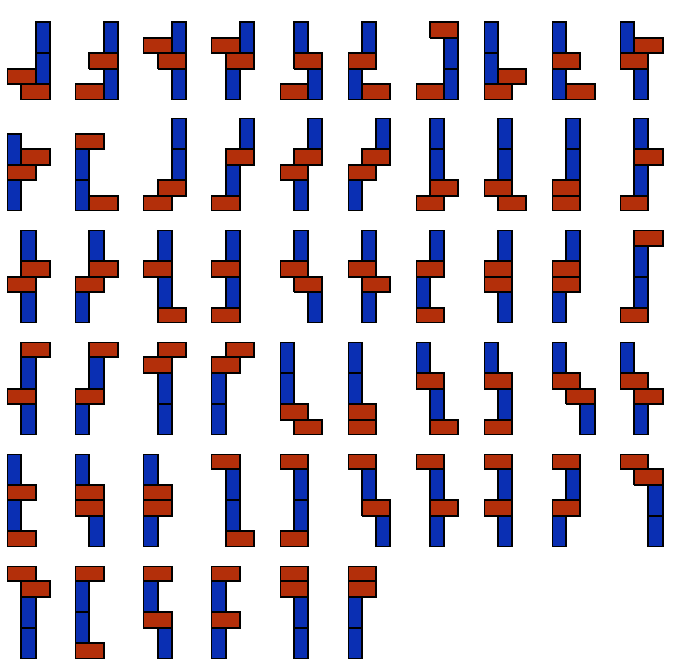

In [17]:
# Tall tower constraints

# tall_subset = four_block_superset[(four_block_superset.tower_height >= 5) &
#                                   (four_block_superset.tower_width <= 3)].reset_index()

tall_subset = silhouette_superset[(silhouette_superset.tower_type == 'tall')].reset_index()

utils.draw_towers([utils.worldify(w, 
                                  block_dims = block_dims, 
#                                   block_colors = black,
                                  block_colors = block_colors,
                                 ) 
                   for w in tall_subset['stim']],
                 figsize=(12,12))

print(str(len(tall_subset))+ ' vertical towers')

### Wide towers smooshed directly on top of each other

Notes:
- Square-aperture towers 
    - Special case because a) they're 3-blocks wide not 4, and hence b) aligning them to the left misses out on a bunch of interesting structures.
    - Consider adding a right-aligned square-aperture.


In [20]:
vert_composition_attempts_matrix = np.array([[compose_vertically(stim_a, stim_b)\
                             for stim_a in wide_subset['stim']]\
                                 for stim_b in wide_subset['stim']])

In [21]:
vert_composition_attempts = [compose_vertically(stim_a, stim_b)\
                             for stim_a in wide_subset['stim'] \
                                 for stim_b in wide_subset['stim']]

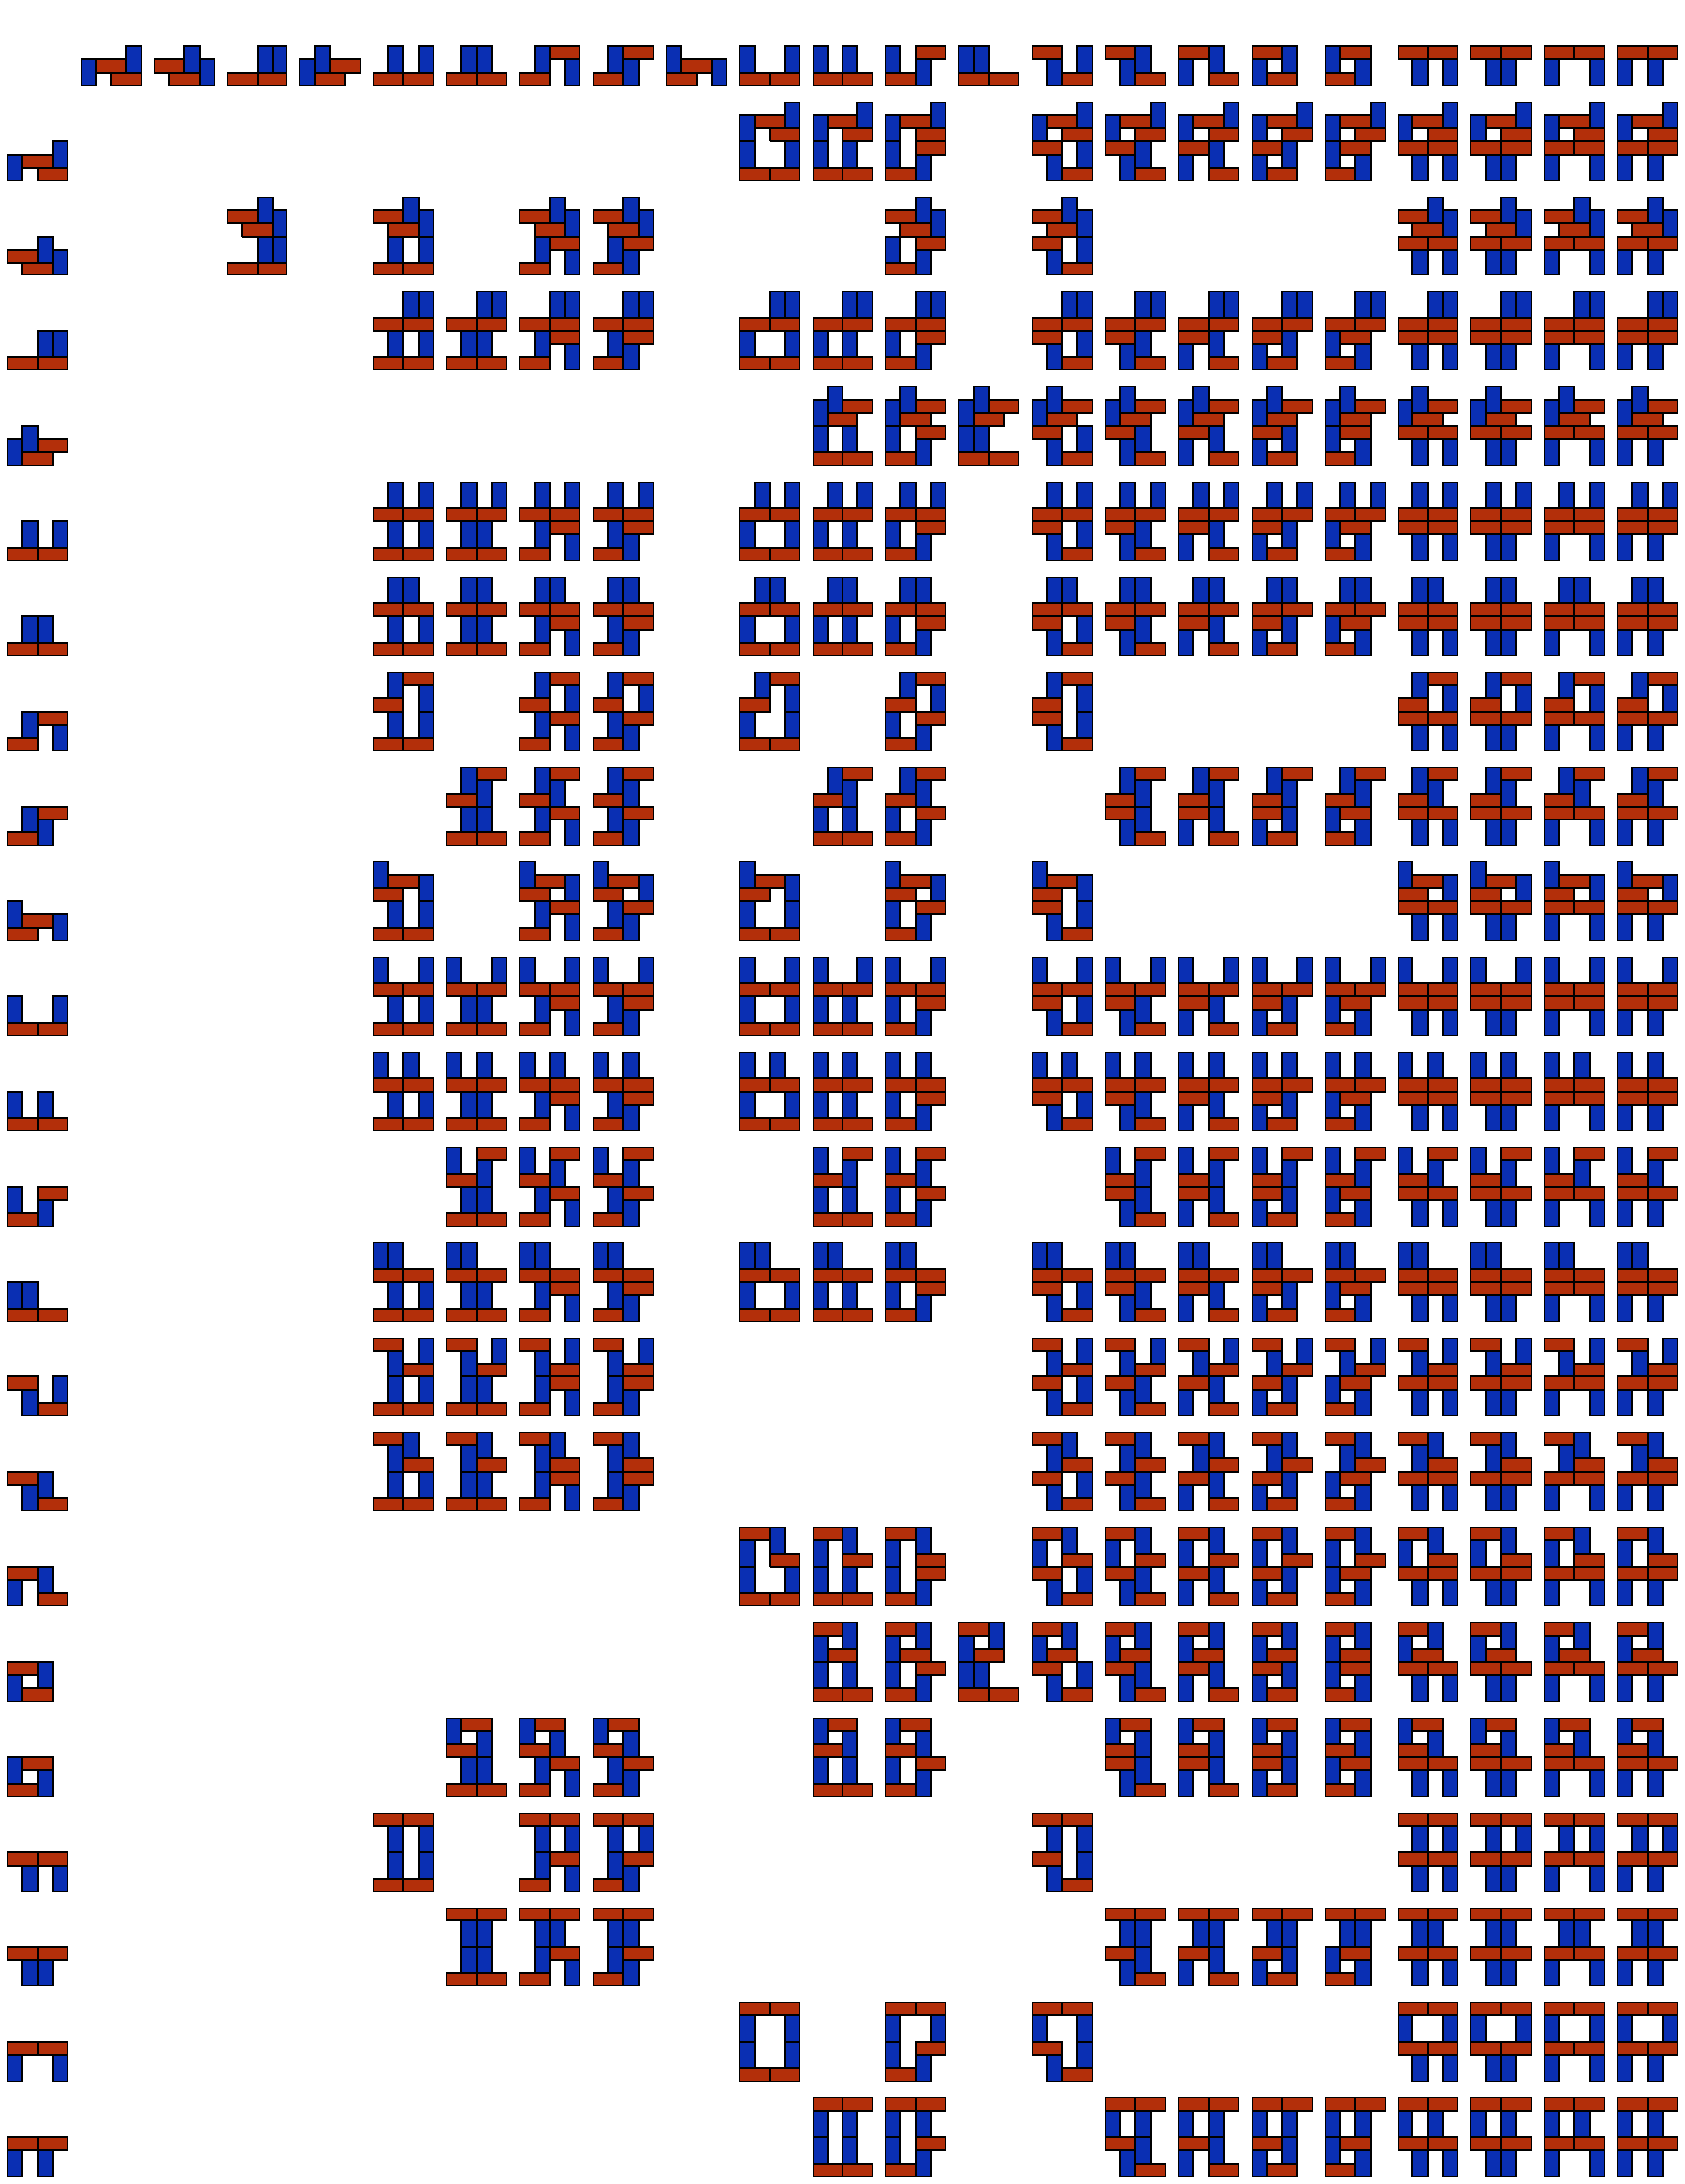

In [51]:
n_towers = vert_composition_attempts_matrix.shape[0]

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 40))

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    #grab tower
    world = utils.worldify(wide_subset['stim'][i], block_dims = block_dims, block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
# iterate over towers
for i in range(0, n_towers):
    for j in range(0, n_towers):
        if vert_composition_attempts_matrix[i,j,0]:
            world = vert_composition_attempts_matrix[i,j,1]
            utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,j+1])

### Tall towers smooshed as close as possible

In [23]:
horz_composition_attempts_matrix = np.array([[compose_horizontally(stim_a, stim_b)\
                             for stim_a in tall_subset['stim']]\
                                 for stim_b in tall_subset['stim']])

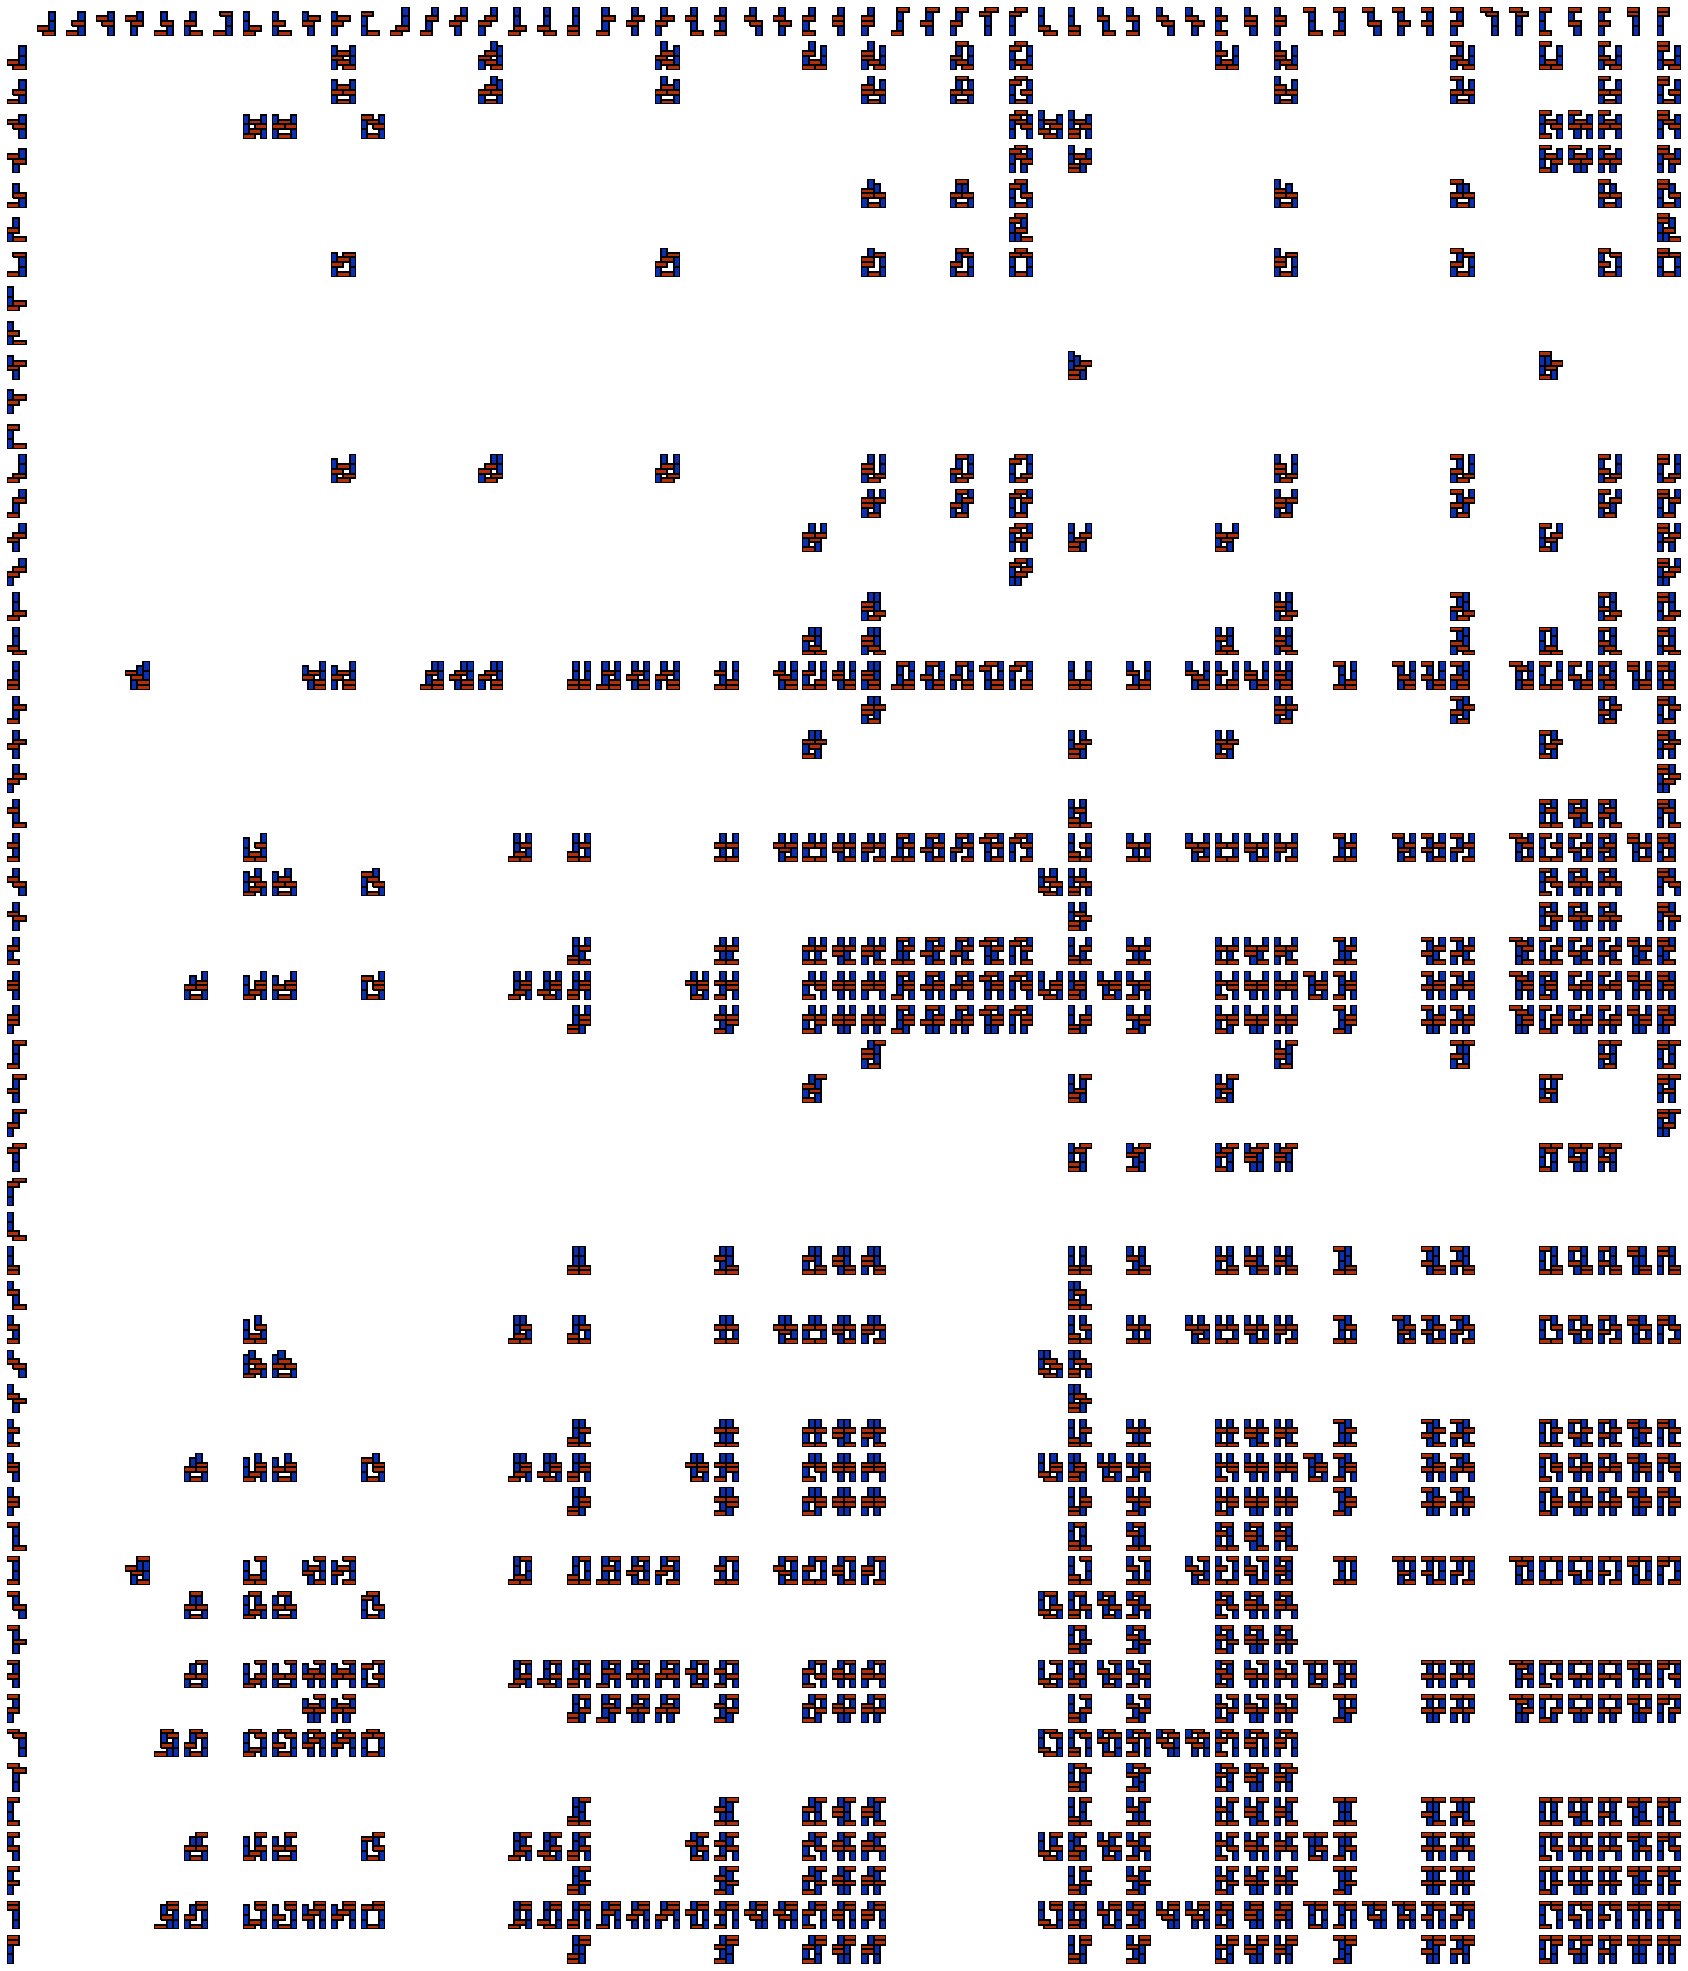

In [68]:
n_towers = horz_composition_attempts_matrix.shape[0]

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 36) )

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    world = utils.worldify(tall_subset['stim'][i], block_dims = block_dims, block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
# iterate over towers
for i in range(0, n_towers):
    for j in range(0, n_towers):
        if horz_composition_attempts_matrix[i,j,0]:
            world = horz_composition_attempts_matrix[i,j,1]
            utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,j+1])

In [24]:
vert_maps = np.array(list(map(lambda x: utils.convert_to_str(x.block_map),
                  vert_composition_attempts_matrix[:,:,1].flatten())))

horz_maps = np.array(list(map(lambda x: utils.convert_to_str(x.block_map),
                  horz_composition_attempts_matrix[:,:,1].flatten())))

In [25]:
importlib.reload(utils)

<module 'blockworld_helpers' from '/Users/will/compositional-abstractions/stimuli/blockworld_helpers.py'>

### Make dataframes of composite towers for horizontal and vertical merges

In [23]:
df_wide_composites = pd.DataFrame()

for i, tower_left in enumerate(wide_subset['stim']):
    for j, tower_right in enumerate(wide_subset['stim']):
        composite = compose_vertically(tower_left, tower_right)
        if composite[0]: #check if successful composition
            df_wide_composites = df_wide_composites.append({
                'composite': composite[1], #world
                #'offset': composite[2], # no offset for vertical stacks
                'block_map': composite[1].block_map,
                'block_dict': composite[1].get_block_dict()['blocks'],
                'block_str': utils.convert_to_str(composite[1].block_map),
                'tower_left': tower_left,
                'tower_right': tower_right,
                'tower_left_subset_index': i,
                'tower_right_subset_index': j,
                'tower_type': 'wide'
            }, ignore_index=True)


In [24]:
df_tall_composites = pd.DataFrame()

for i, tower_bottom in enumerate(tall_subset['stim']):
    for j, tower_top in enumerate(tall_subset['stim']):
        composite = compose_horizontally(tower_bottom, tower_top)
        if composite[0]: #check if successful composition
            df_tall_composites = df_tall_composites.append({
                'composite': composite[1], #world
                'block_map': composite[1].block_map,
                'block_dict': composite[1].get_block_dict()['blocks'],
                'block_str': utils.convert_to_str(composite[1].block_map),
                'offset': composite[2],
                'tower_bottom': tower_bottom,
                'tower_top': tower_top,
                'tower_bottom_subset_index': i,
                'tower_top_subset_index': j,
                'tower_type': 'tall'
            }, ignore_index=True)
    

In [28]:
df_tall_composites

,block_dict,block_map,block_str,composite,offset,tower_bottom,tower_bottom_subset_index,tower_top,tower_top_subset_index,tower_type
0,"[{'x': 2, 'y': 0, 'height': 1, 'width': 2}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000000100000011000011110000011100...,<blockworld_helpers.World object at 0x7f98efdf...,2.0,"[{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...",3.0,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...",18.0,tall
1,"[{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000001100000011000011110000011100...,<blockworld_helpers.World object at 0x7f9917d4...,2.0,"[{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...",3.0,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...",44.0,tall
2,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000011000000111000001010000011100...,<blockworld_helpers.World object at 0x7f98f0c6...,1.0,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...",4.0,"[{'x': 2, 'y': 0, 'height': 2, 'width': 1}, {'...",49.0,tall
3,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000001100000111000001010000011100...,<blockworld_helpers.World object at 0x7f98ef4c...,2.0,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...",4.0,"[{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...",54.0,tall
4,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000000100000101000001110000111100...,<blockworld_helpers.World object at 0x7f98f310...,2.0,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...",5.0,"[{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...",27.0,tall
...,...,...,...,...,...,...,...,...,...,...
651,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000111100001110000010100000101000...,<blockworld_helpers.World object at 0x7f98ef5b...,2.0,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...",55.0,"[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...",51.0,tall
652,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000111100001110000010100000101100...,<blockworld_helpers.World object at 0x7f98ef5b...,2.0,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...",55.0,"[{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...",52.0,tall
653,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000111100001110000010100000101100...,<blockworld_helpers.World object at 0x7f98ef58...,2.0,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...",55.0,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...",53.0,tall
654,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",0000000000000000111100001111000010010000100100...,<blockworld_helpers.World object at 0x7f98ef58...,2.0,"[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...",55.0,"[{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...",54.0,tall


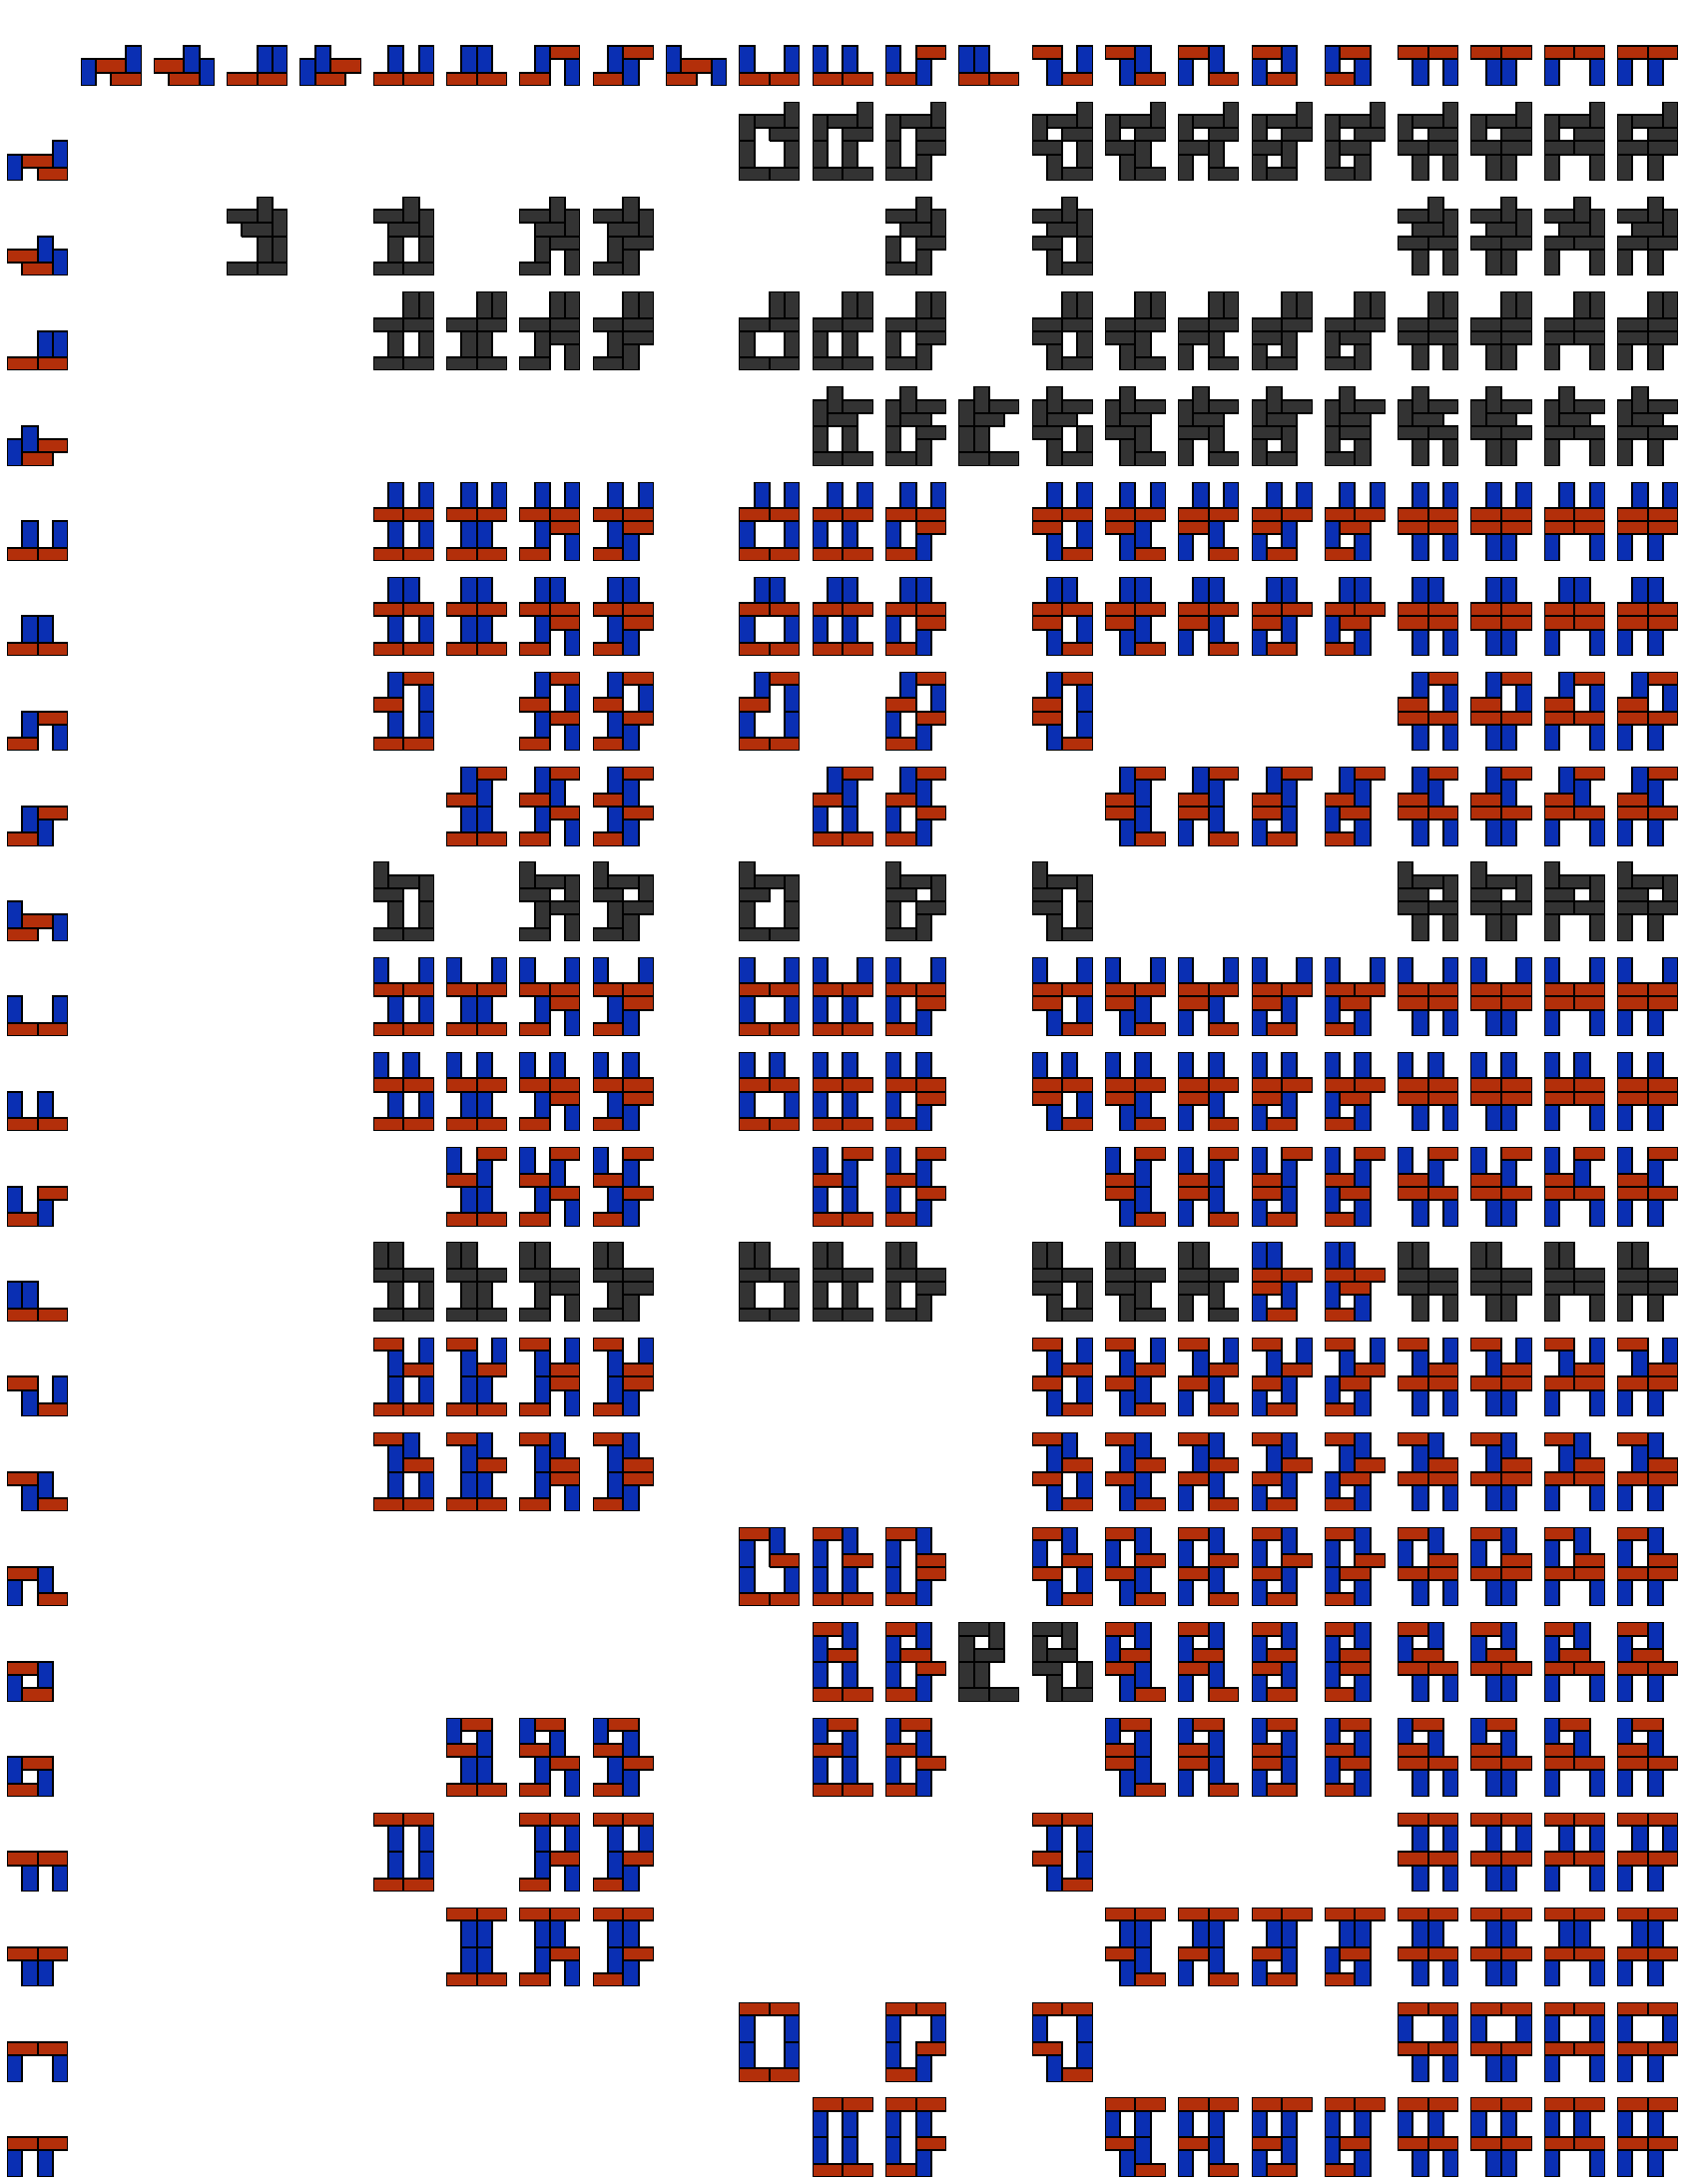

In [132]:
# attempt at coloring towers

n_towers = vert_composition_attempts_matrix.shape[0]

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 40))

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    #grab tower
    world = utils.worldify(wide_subset['stim'][i], 
                           block_dims = block_dims, 
                           block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
# iterate over towers
for i in range(0, n_towers):
    for j in range(0, n_towers):
        if vert_composition_attempts_matrix[i,j,0]:
            world = vert_composition_attempts_matrix[i,j,1]
            if utils.convert_to_str(world.block_map) in horz_maps:
                utils.tower_subplot(utils.patches_for_world(world.blocks), 
                                axs[i+1,j+1])
            else:
                world_grey = utils.worldify(world.get_block_dict()['blocks'],
                                       block_dims = block_dims, 
                                       block_colors = grey)
                utils.tower_subplot(utils.patches_for_world(world_grey.blocks), 
                                axs[i+1,j+1])

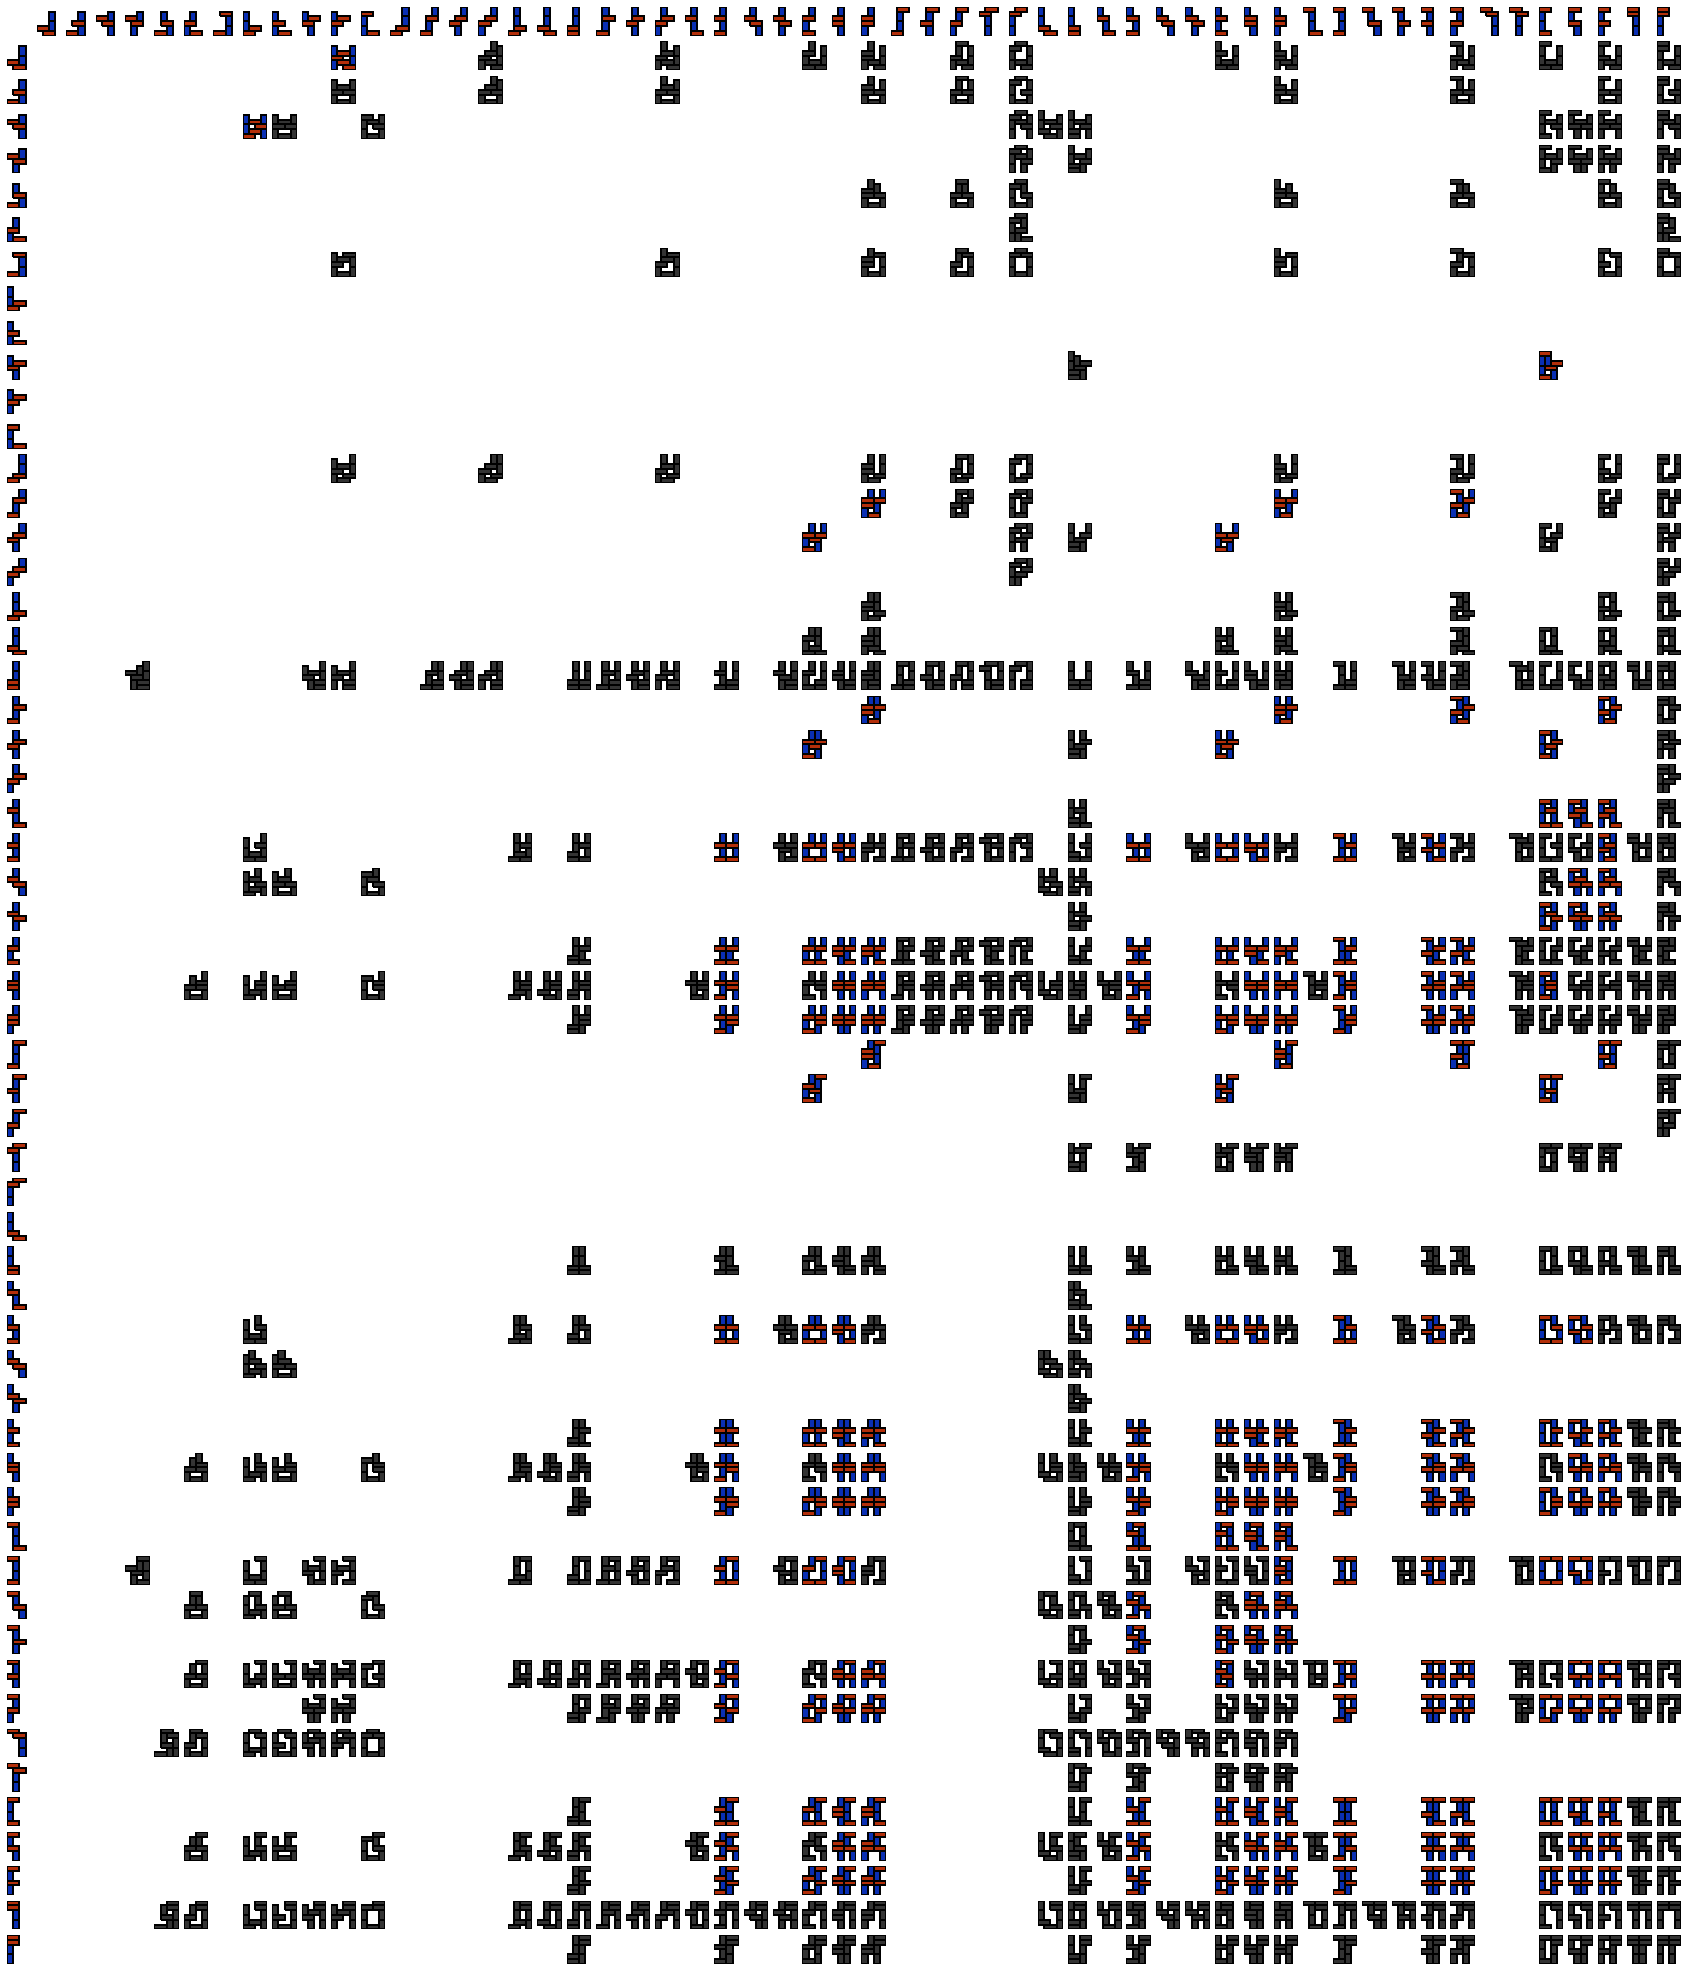

In [134]:
n_towers = horz_composition_attempts_matrix.shape[0]

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 36) )

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    world = utils.worldify(tall_subset['stim'][i], 
                           block_dims = block_dims, 
                           block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
# iterate over towers
for i in range(0, n_towers):
    for j in range(0, n_towers):
        if horz_composition_attempts_matrix[i,j,0]:
            world = horz_composition_attempts_matrix[i,j,1]
            if utils.convert_to_str(world.block_map) in vert_maps:
                utils.tower_subplot(utils.patches_for_world(world.blocks), 
                                axs[i+1,j+1])
            else:
                world_grey = utils.worldify(world.get_block_dict()['blocks'],
                                       block_dims = block_dims, 
                                       block_colors = grey)
                utils.tower_subplot(utils.patches_for_world(world_grey.blocks), 
                                axs[i+1,j+1])

## exploring width 2 towers only for tall

18 vertical towers


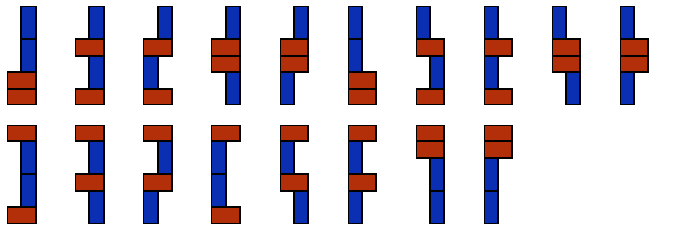

In [26]:
unique_by_silhoutte = True

tall_subset_w2 = four_block_superset[(four_block_superset.tower_height >= 5) &
                                  (four_block_superset.tower_width == 2)].reset_index()

# get unique silhouettes
if unique_by_silhoutte:
    tall_subset_w2 = tall_subset_w2.groupby('silhouette_str').agg('first').reset_index()


utils.draw_towers([utils.worldify(w, 
                                  block_dims = block_dims, 
#                                   block_colors = black,
                                  block_colors = block_colors,
                                 ) 
                   for w in tall_subset_w2['stim']],
                 figsize=(12,4))

print(str(len(tall_subset_w2))+ ' vertical towers')

In [27]:
horz_composition_tall_subset_w2 = np.array([[compose_horizontally(stim_a, stim_b)\
                             for stim_a in tall_subset_w2['stim']]\
                                 for stim_b in tall_subset_w2['stim']])

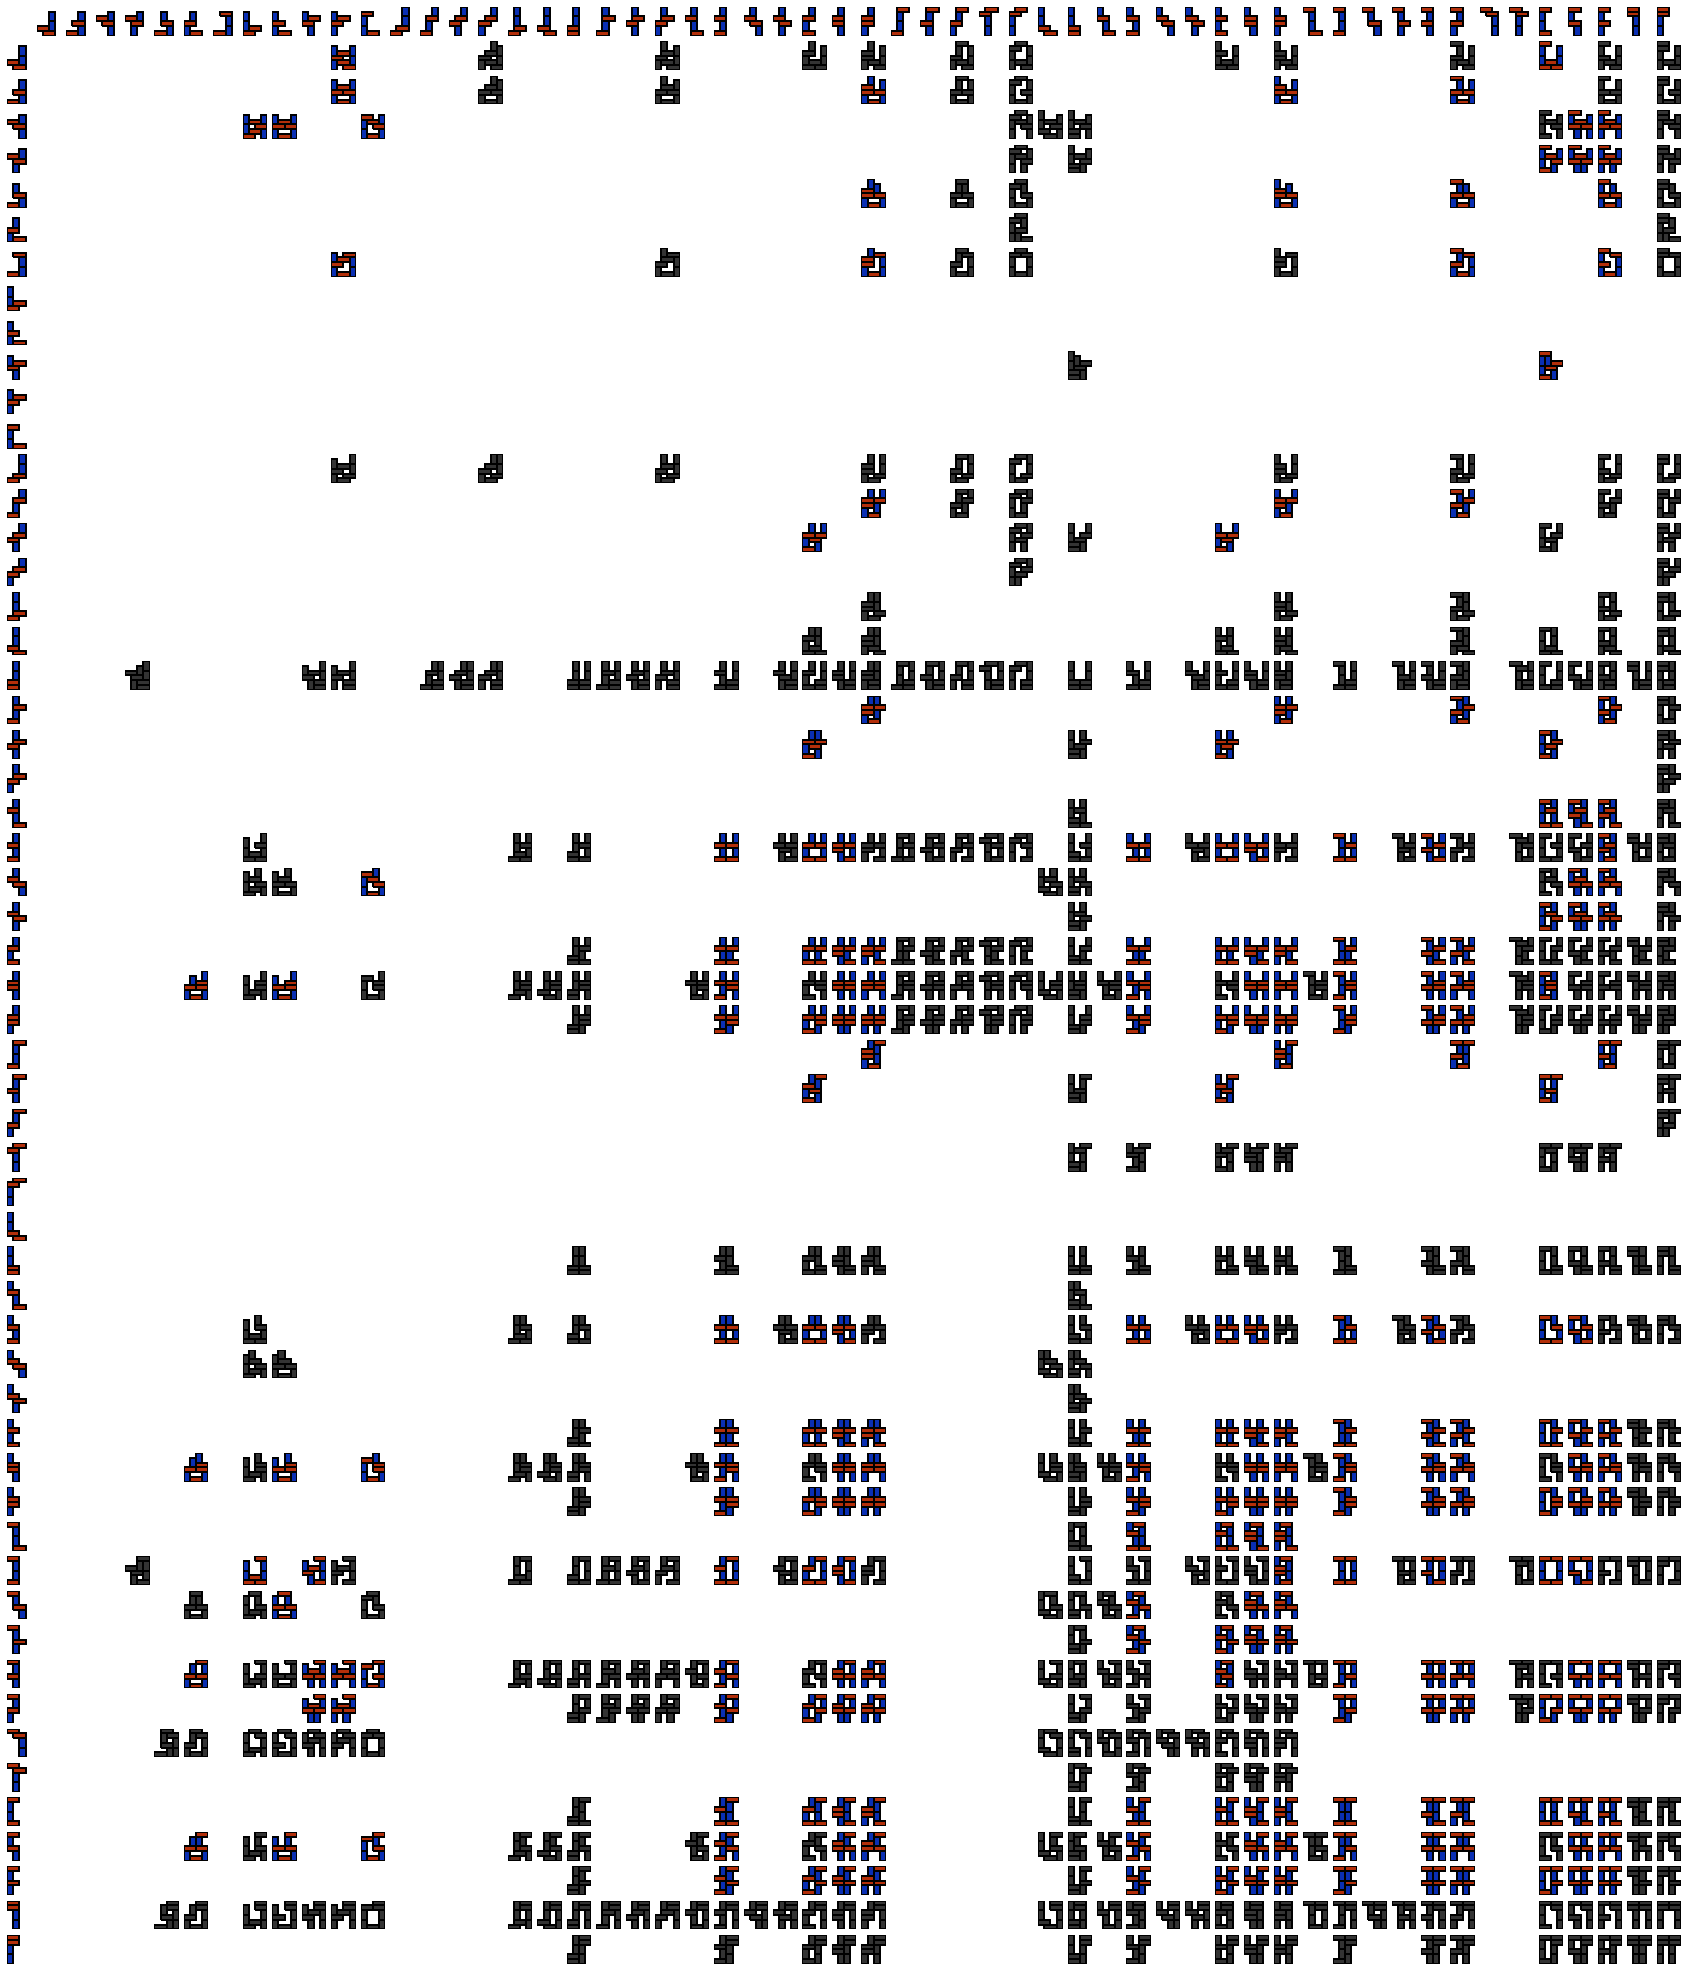

In [31]:
# horz_composition_tall_subset_w2

n_towers = horz_composition_attempts_matrix.shape[0]

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 36) )

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    world = utils.worldify(tall_subset['stim'][i], 
                           block_dims = block_dims, 
                           block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
# iterate over towers
for i in range(0, n_towers):
    for j in range(0, n_towers):
        if horz_composition_attempts_matrix[i,j,0]:
            world = horz_composition_attempts_matrix[i,j,1]
            if utils.convert_to_str(world.block_map) in vert_maps:
                utils.tower_subplot(utils.patches_for_world(world.blocks), 
                                axs[i+1,j+1])
            else:
                world_grey = utils.worldify(world.get_block_dict()['blocks'],
                                       block_dims = block_dims, 
                                       block_colors = grey)
                utils.tower_subplot(utils.patches_for_world(world_grey.blocks), 
                                axs[i+1,j+1])
                
                

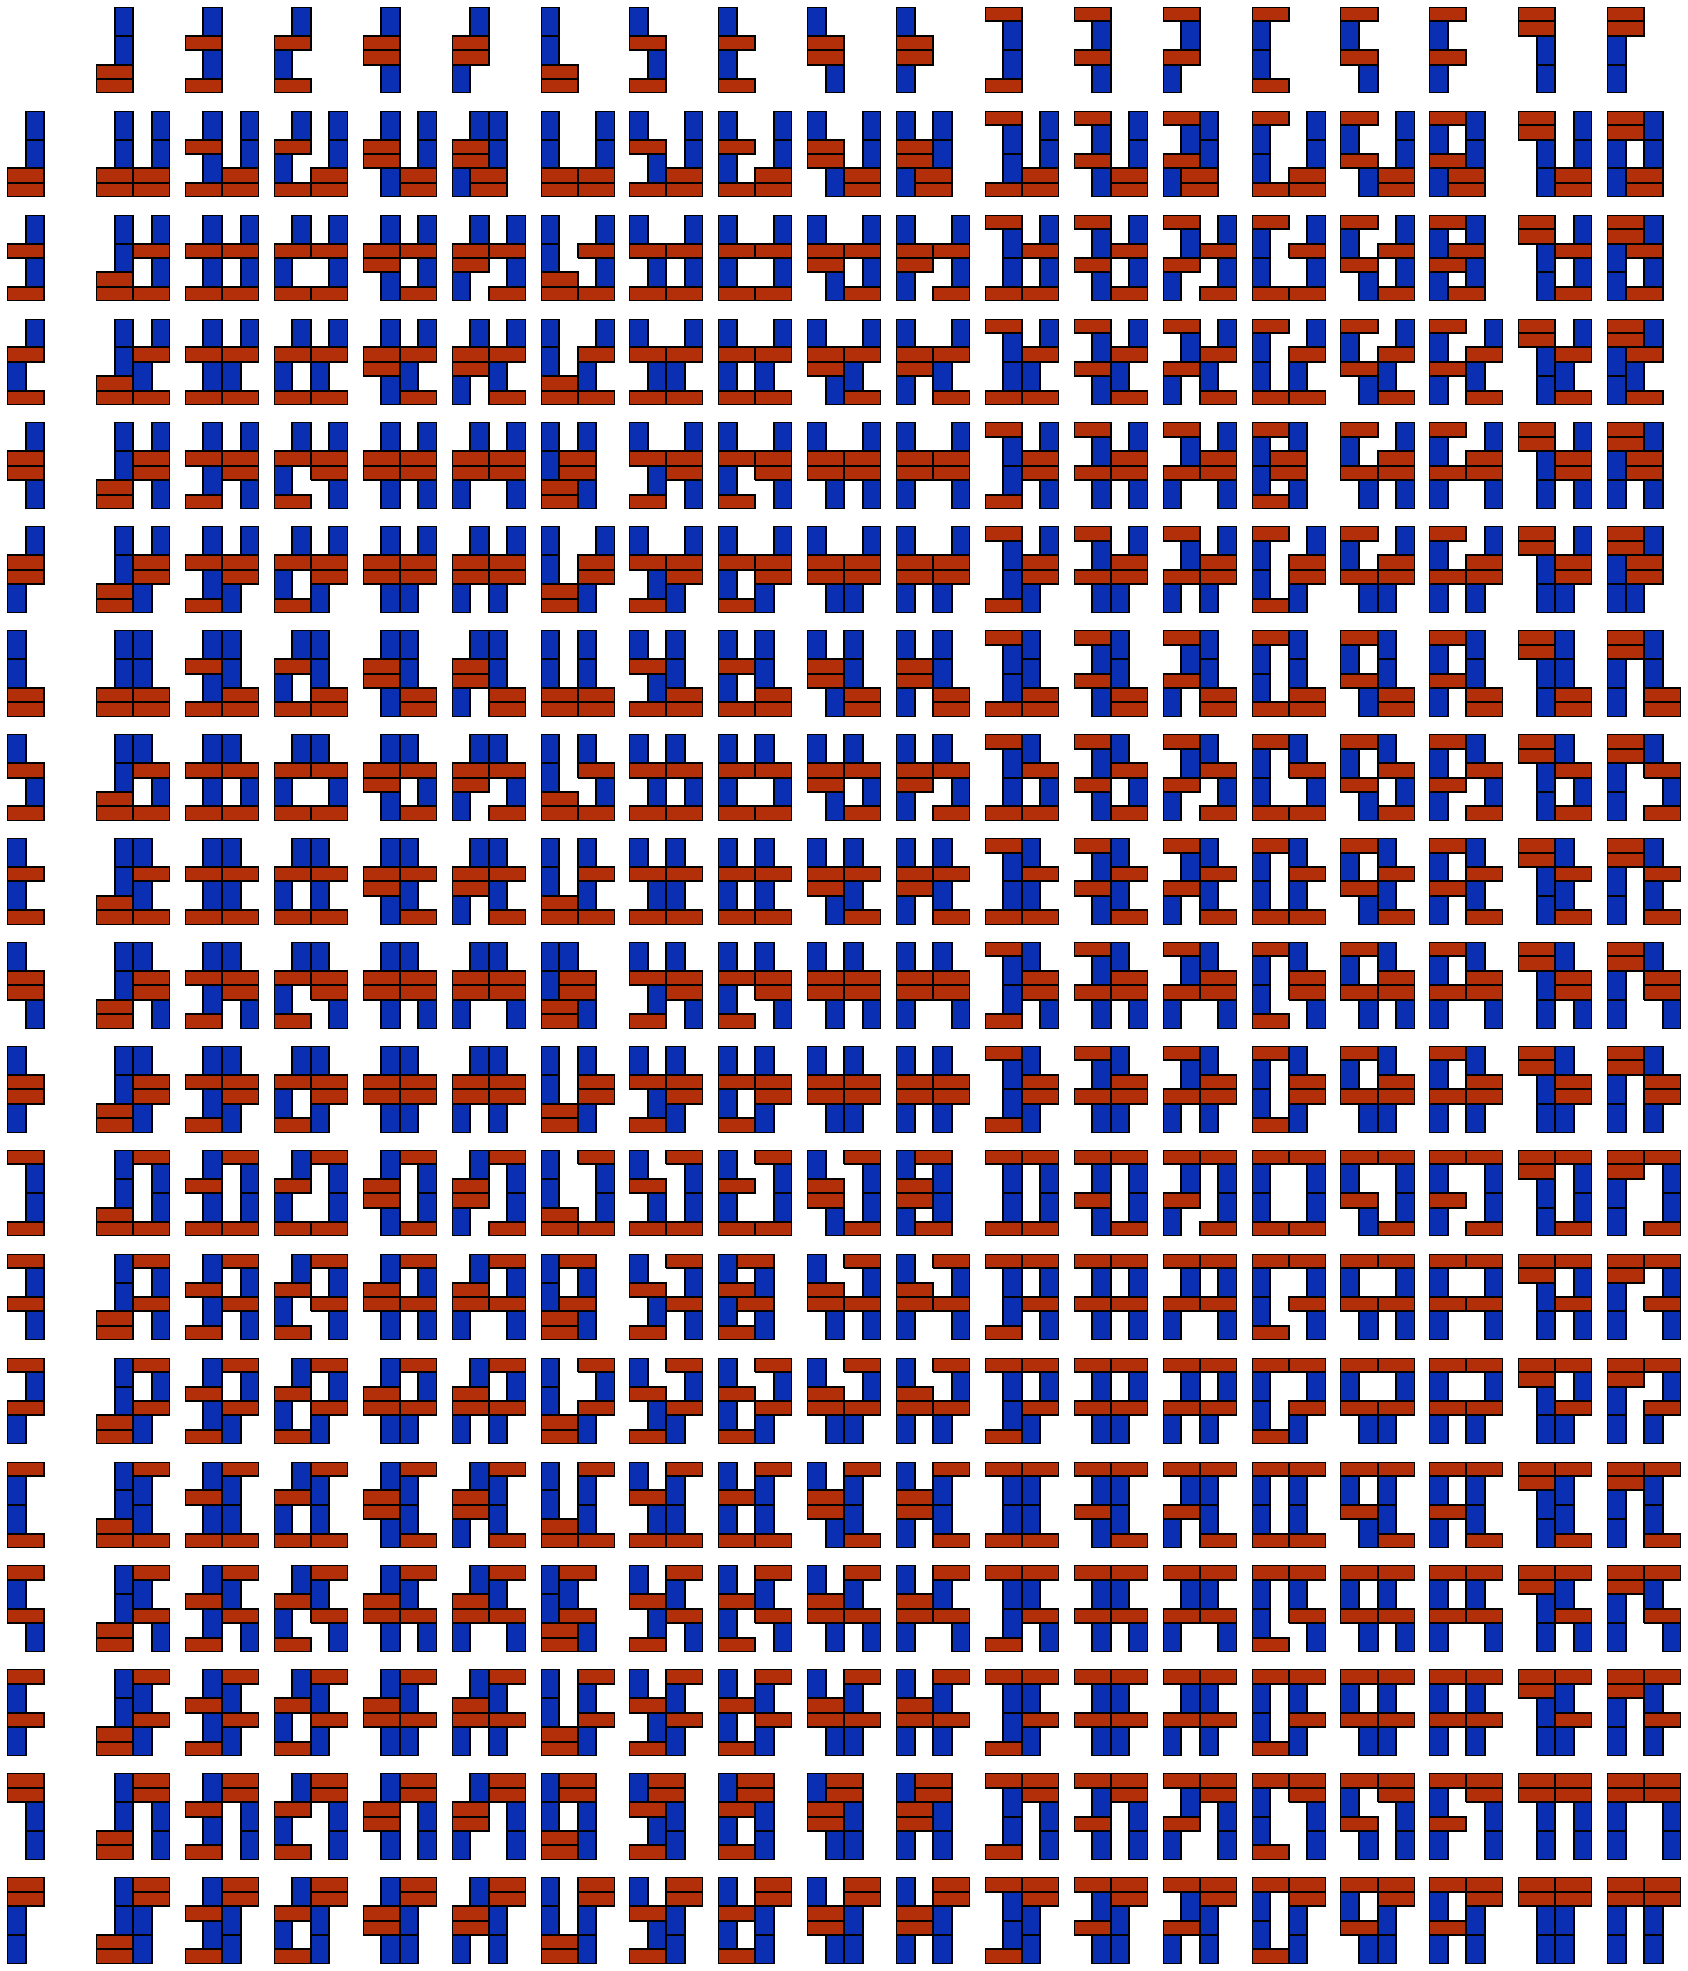

In [80]:
n_towers = horz_composition_tall_subset_w2.shape[0]

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 36) )

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    world = utils.worldify(tall_subset_w2['stim'][i], block_dims = block_dims, block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
# iterate over towers
for i in range(0, n_towers):
    for j in range(0, n_towers):
        if horz_composition_tall_subset_w2[i,j,0]:
            world = horz_composition_tall_subset_w2[i,j,1]
            utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,j+1])

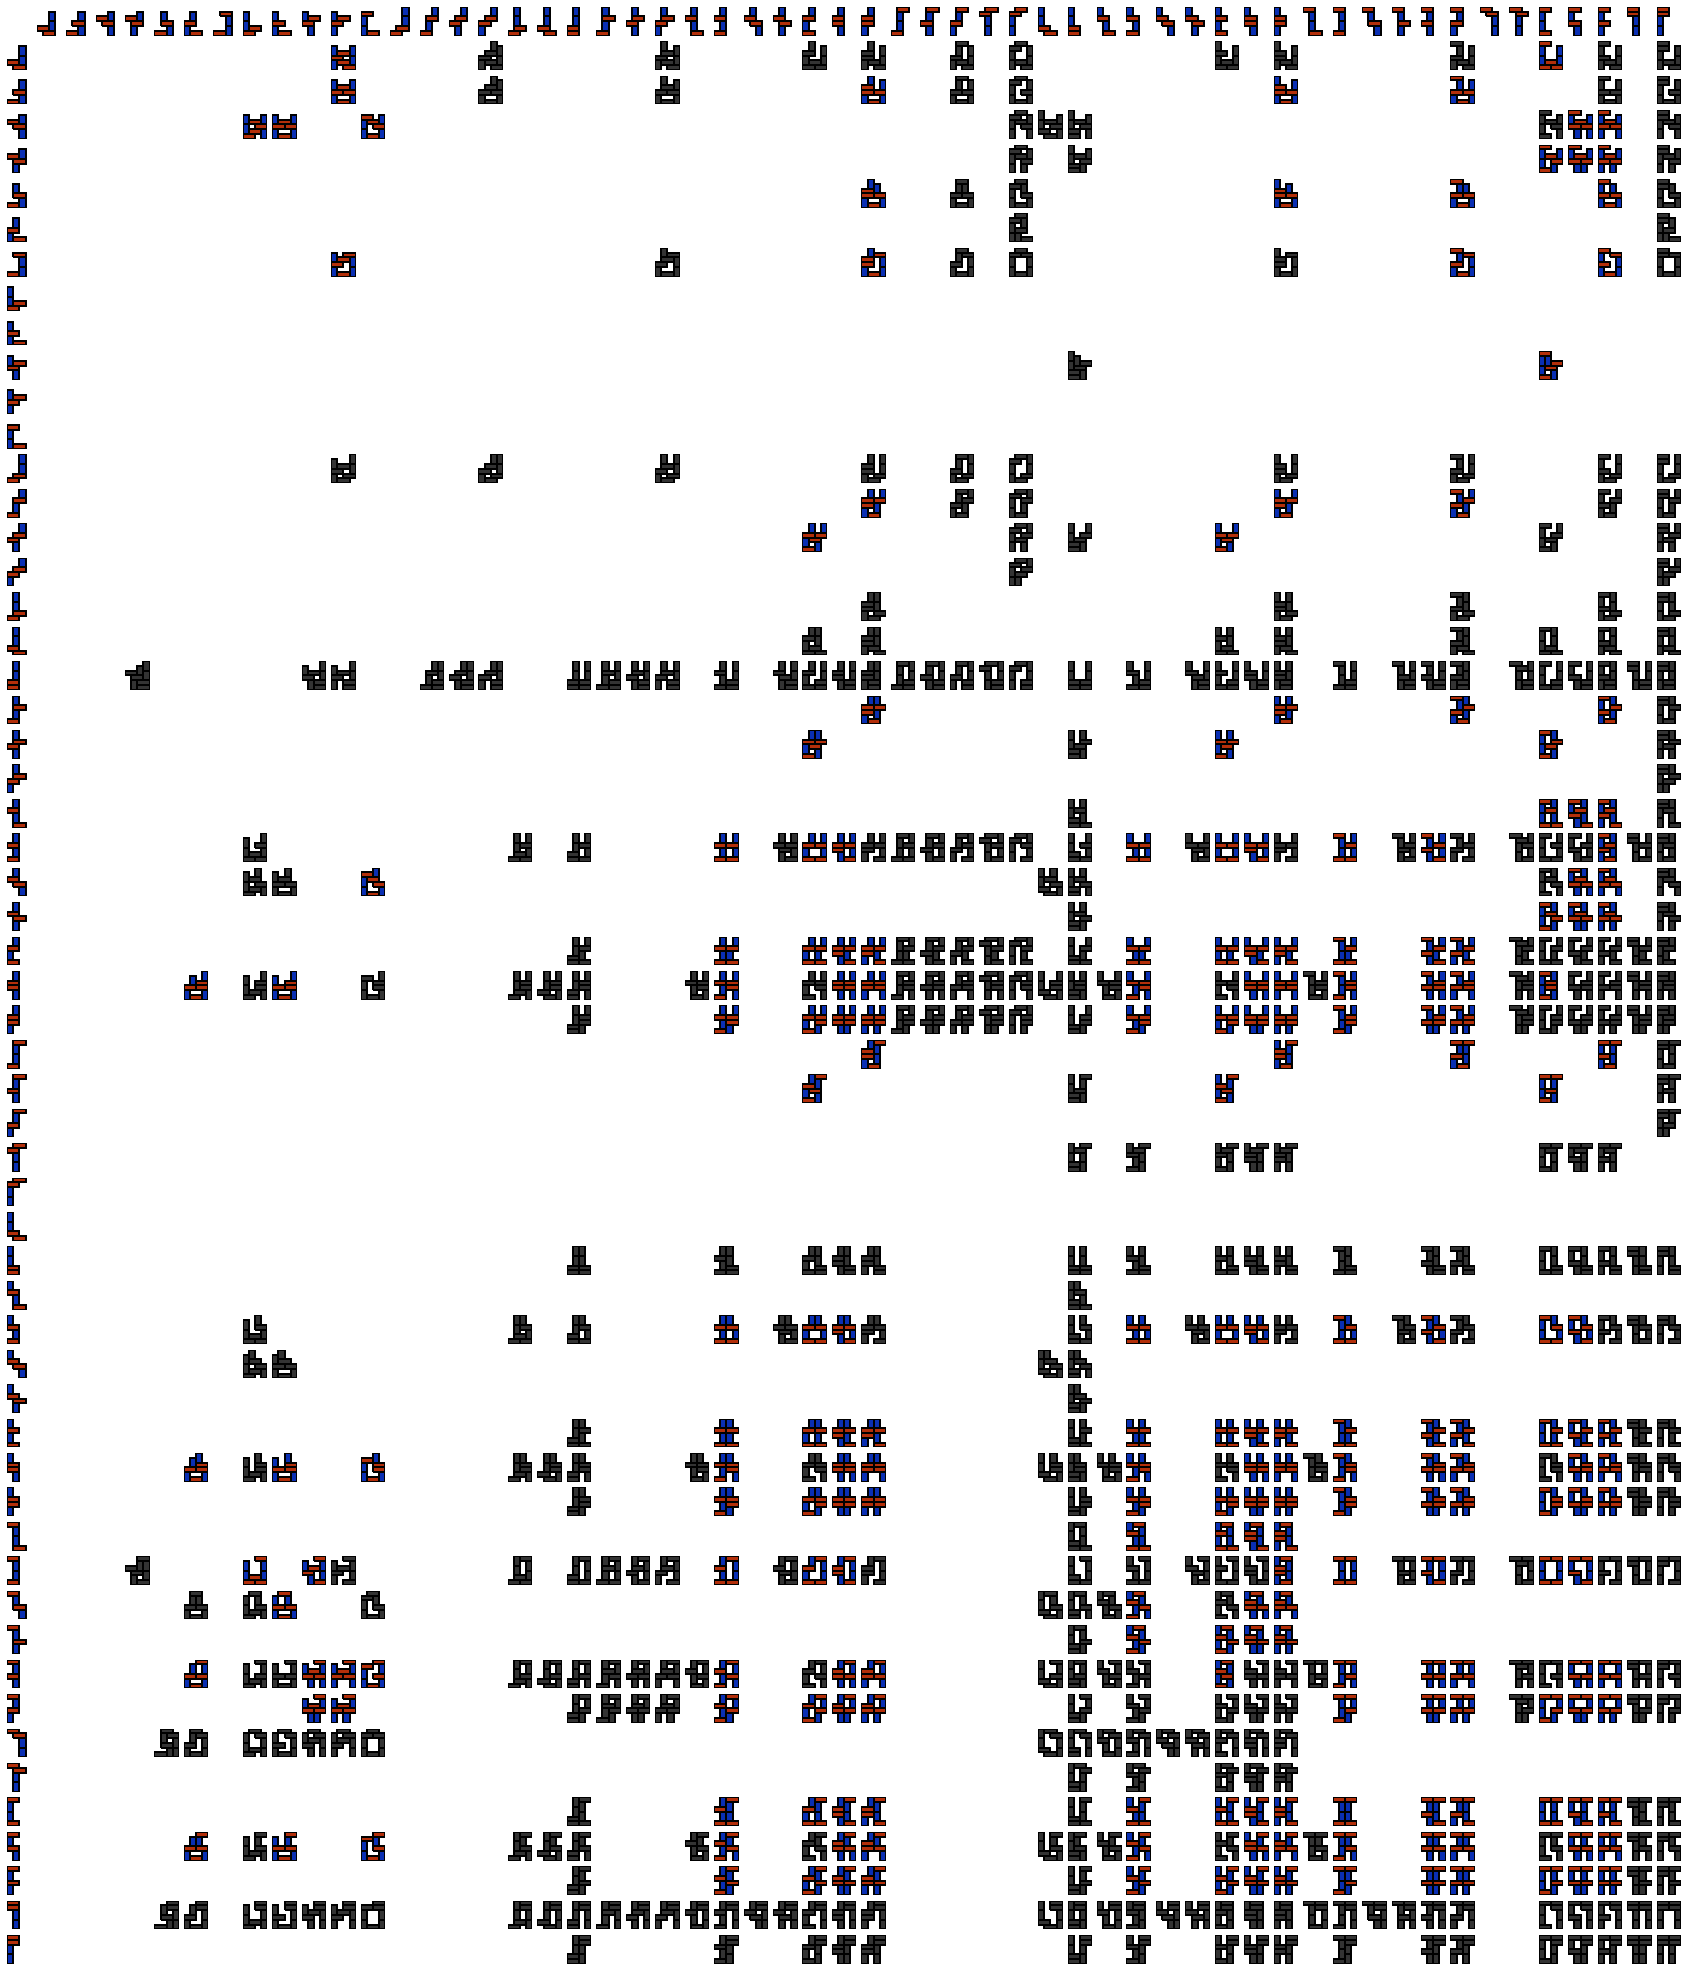

In [32]:
n_towers = horz_composition_attempts_matrix.shape[0]

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 36) )

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    world = utils.worldify(tall_subset['stim'][i], block_dims = block_dims, block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
# iterate over towers
for i in range(0, n_towers):
    for j in range(0, n_towers):
        if horz_composition_attempts_matrix[i,j,0]:
            world = horz_composition_attempts_matrix[i,j,1]
            if utils.convert_to_str(world.block_map) in vert_maps:
                utils.tower_subplot(utils.patches_for_world(world.blocks), 
                                axs[i+1,j+1])
            else:
                world_grey = utils.worldify(world.get_block_dict()['blocks'],
                                       block_dims = block_dims, 
                                       block_colors = grey)
                utils.tower_subplot(utils.patches_for_world(world_grey.blocks), 
                                axs[i+1,j+1])

## CA 2.0: Composing tall_width_2 and wide_height_3

Trying separable stims (vertically and horizontally)

18 vertical towers


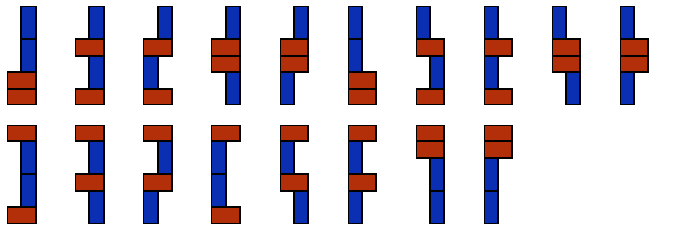

In [28]:
tall_subset_w2 = four_block_superset[(four_block_superset.tower_height >= 5) &
                                  (four_block_superset.tower_width == 2)].reset_index()

# get unique silhouettes
if unique_by_silhoutte:
    tall_subset_w2 = tall_subset_w2.groupby('silhouette_str').agg('first').reset_index()


utils.draw_towers([utils.worldify(w, 
                                  block_dims = block_dims, 
#                                   block_colors = black,
                                  block_colors = block_colors,
                                 ) 
                   for w in tall_subset_w2['stim']],
                 figsize=(12,4))

print(str(len(tall_subset_w2))+ ' vertical towers')

#### explore only width 4 towers.

An alternative may be to include the square-aperture towers but with both alignments

24 horizontal towers with width 4


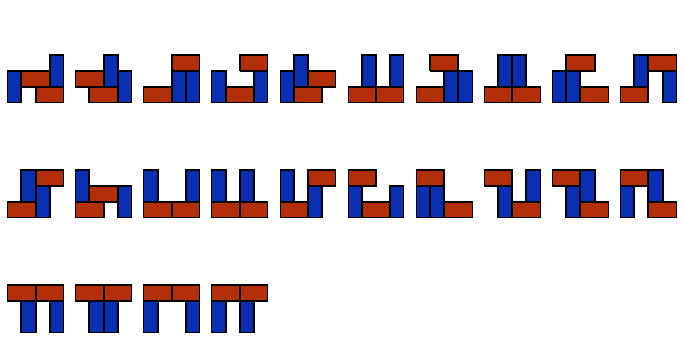

In [29]:
# Wide tower constraints

wide_subset_w4 = four_block_superset[(four_block_superset.tower_height == 3) &
                                    (four_block_superset.tower_width == 4) ].reset_index()

# get unique silhouettes

if unique_by_silhoutte:
    wide_subset_w4 = wide_subset_w4.groupby('silhouette_str').agg('first').reset_index()

utils.draw_towers([utils.worldify(w, 
                                  block_dims = block_dims, 
#                                   block_colors = black,
                                  block_colors = block_colors,
                                 ) 
                   for w in wide_subset_w4['stim']],
                 figsize=(12,6))

print(str(len(wide_subset_w4))+ ' horizontal towers with width 4')

In [30]:
horz_composition_tall_subset_w2 = np.array([[compose_horizontally(stim_a, 
                                                                  stim_b,
                                                                  keep_separable=True)\
                             for stim_a in tall_subset_w2['stim']]\
                                 for stim_b in tall_subset_w2['stim']])

In [31]:
vert_composition_wide_subset_w4 = np.array([[compose_vertically(stim_a, stim_b)\
                             for stim_a in wide_subset_w4['stim']]\
                                 for stim_b in wide_subset_w4['stim']])

In [32]:
horz_maps_w2 = np.array(list(map(lambda x: utils.convert_to_str(x.block_map),
                  horz_composition_tall_subset_w2[:,:,1].flatten())))

vert_maps_w4 = np.array(list(map(lambda x: utils.convert_to_str(x.block_map),
                  vert_composition_wide_subset_w4[:,:,1].flatten())))

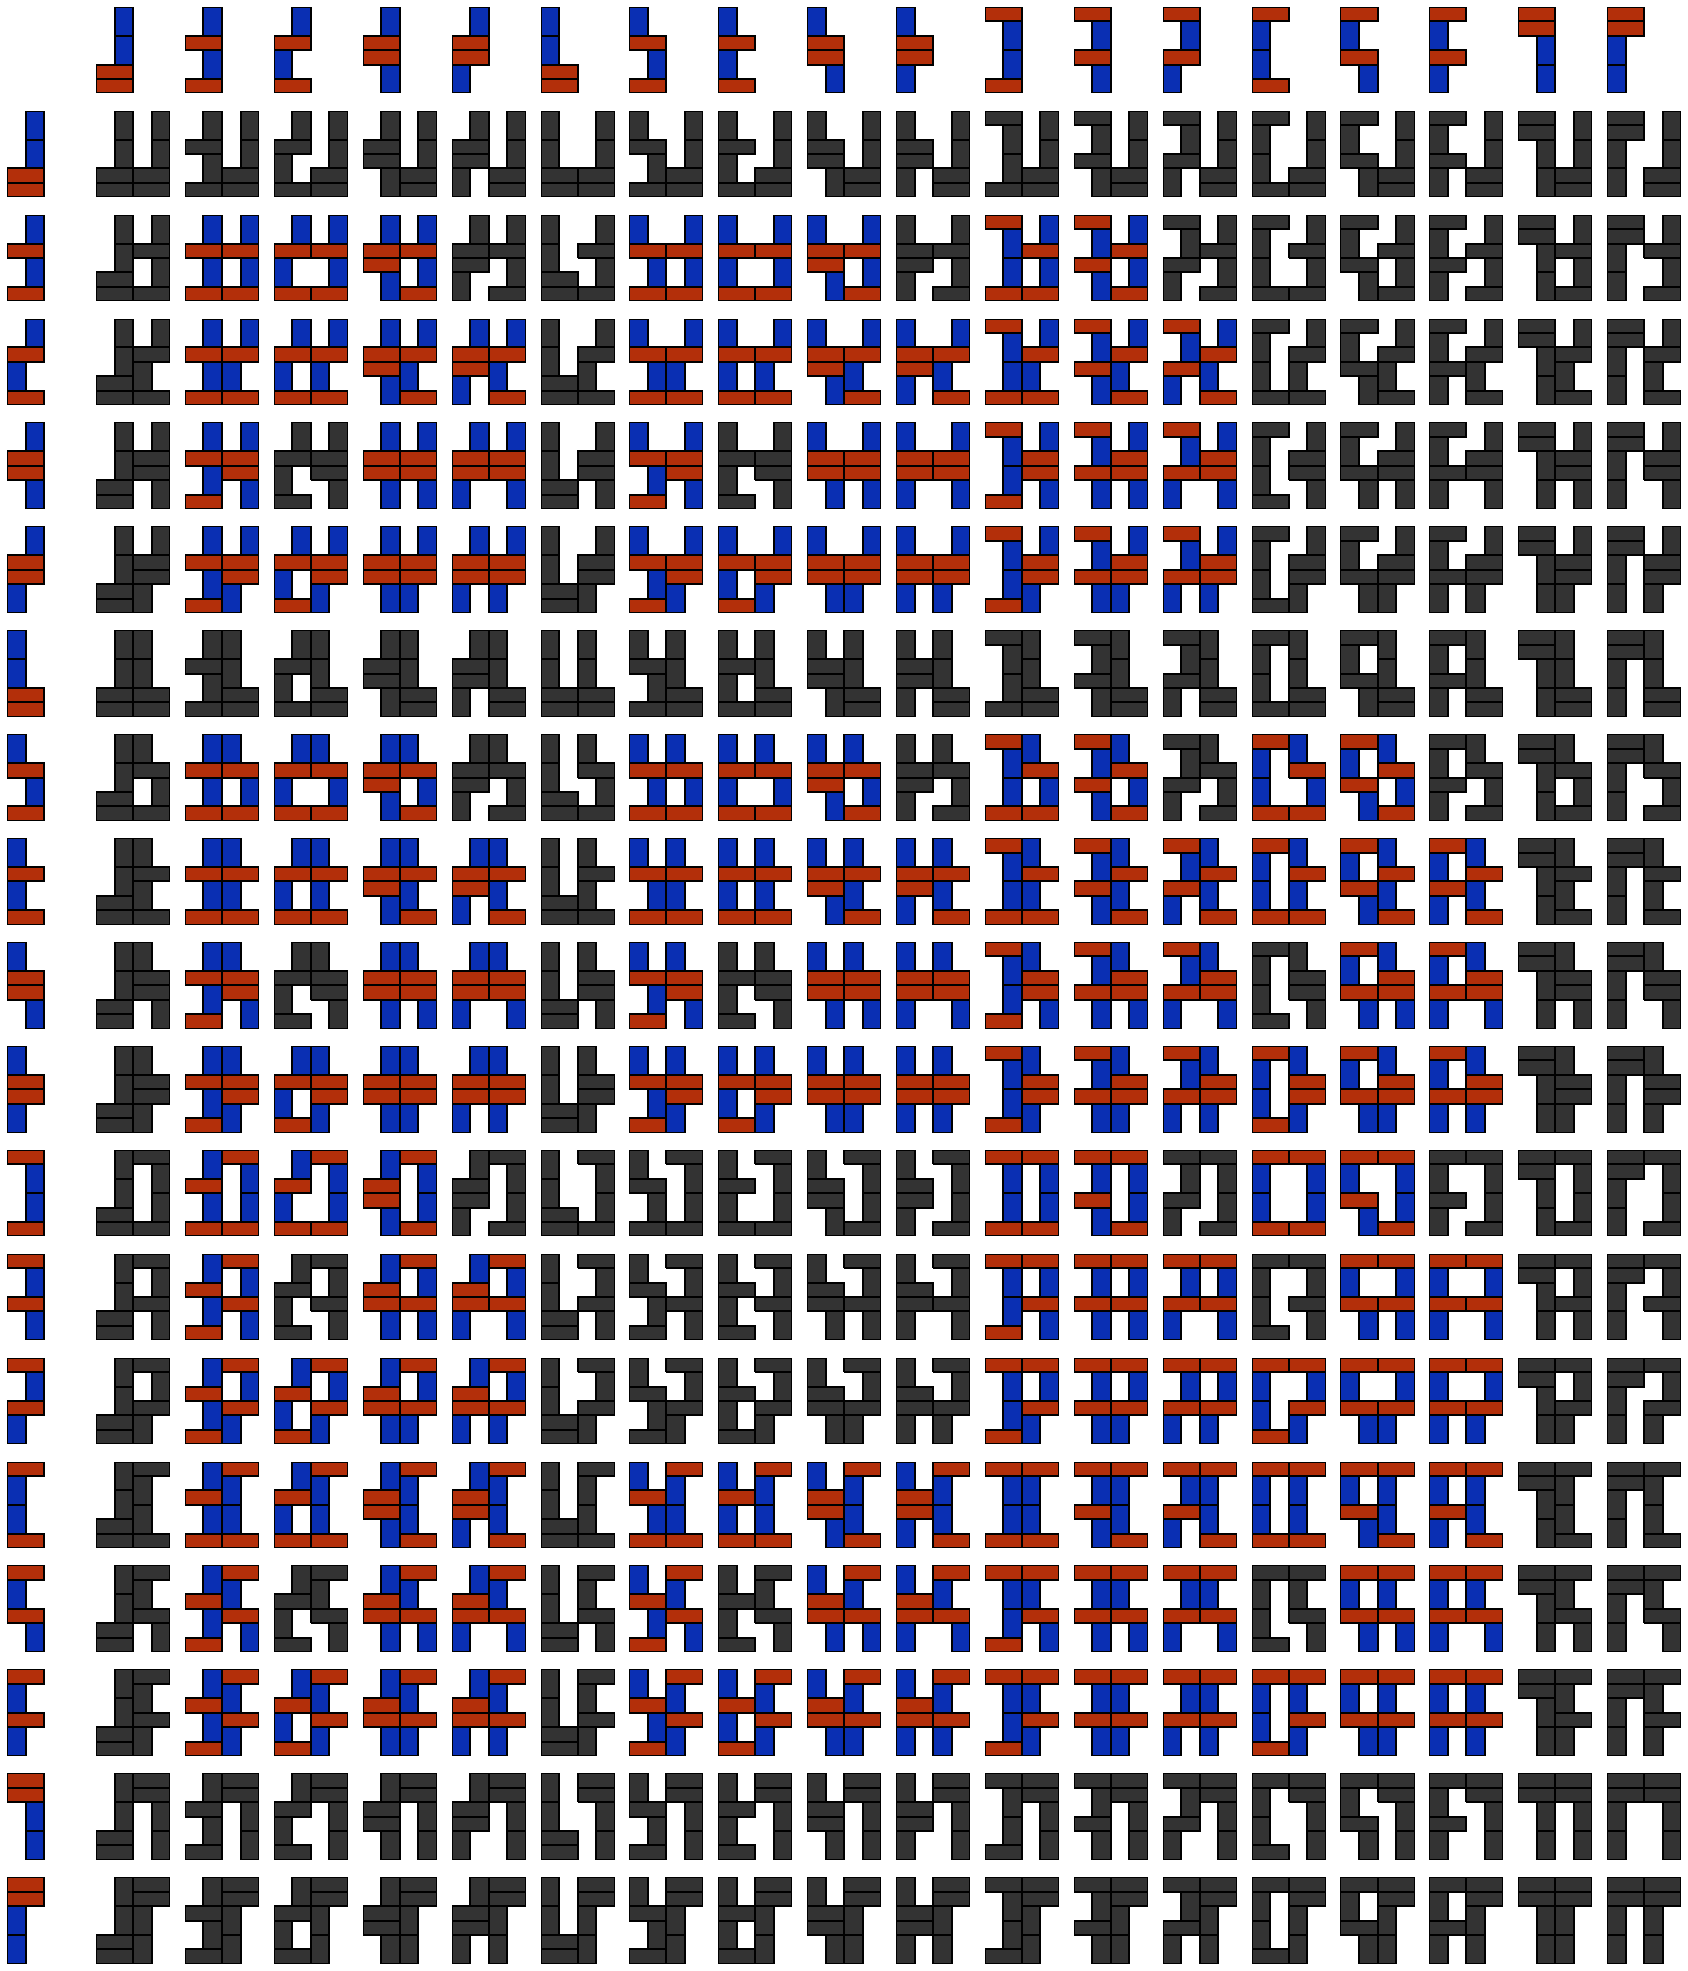

In [33]:
n_towers = horz_composition_tall_subset_w2.shape[0]

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 36) )

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    world = utils.worldify(tall_subset_w2['stim'][i], 
                           block_dims = block_dims, 
                           block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
# iterate over towers
for i in range(0, n_towers):
    for j in range(0, n_towers):
        if horz_composition_tall_subset_w2[i,j,0]:
            world = horz_composition_tall_subset_w2[i,j,1]
            if utils.convert_to_str(world.block_map) in vert_maps_w4:
                utils.tower_subplot(utils.patches_for_world(world.blocks), 
                                axs[i+1,j+1])
            else:
                world_grey = utils.worldify(world.get_block_dict()['blocks'],
                                       block_dims = block_dims, 
                                       block_colors = grey)
                utils.tower_subplot(utils.patches_for_world(world_grey.blocks), 
                                axs[i+1,j+1])

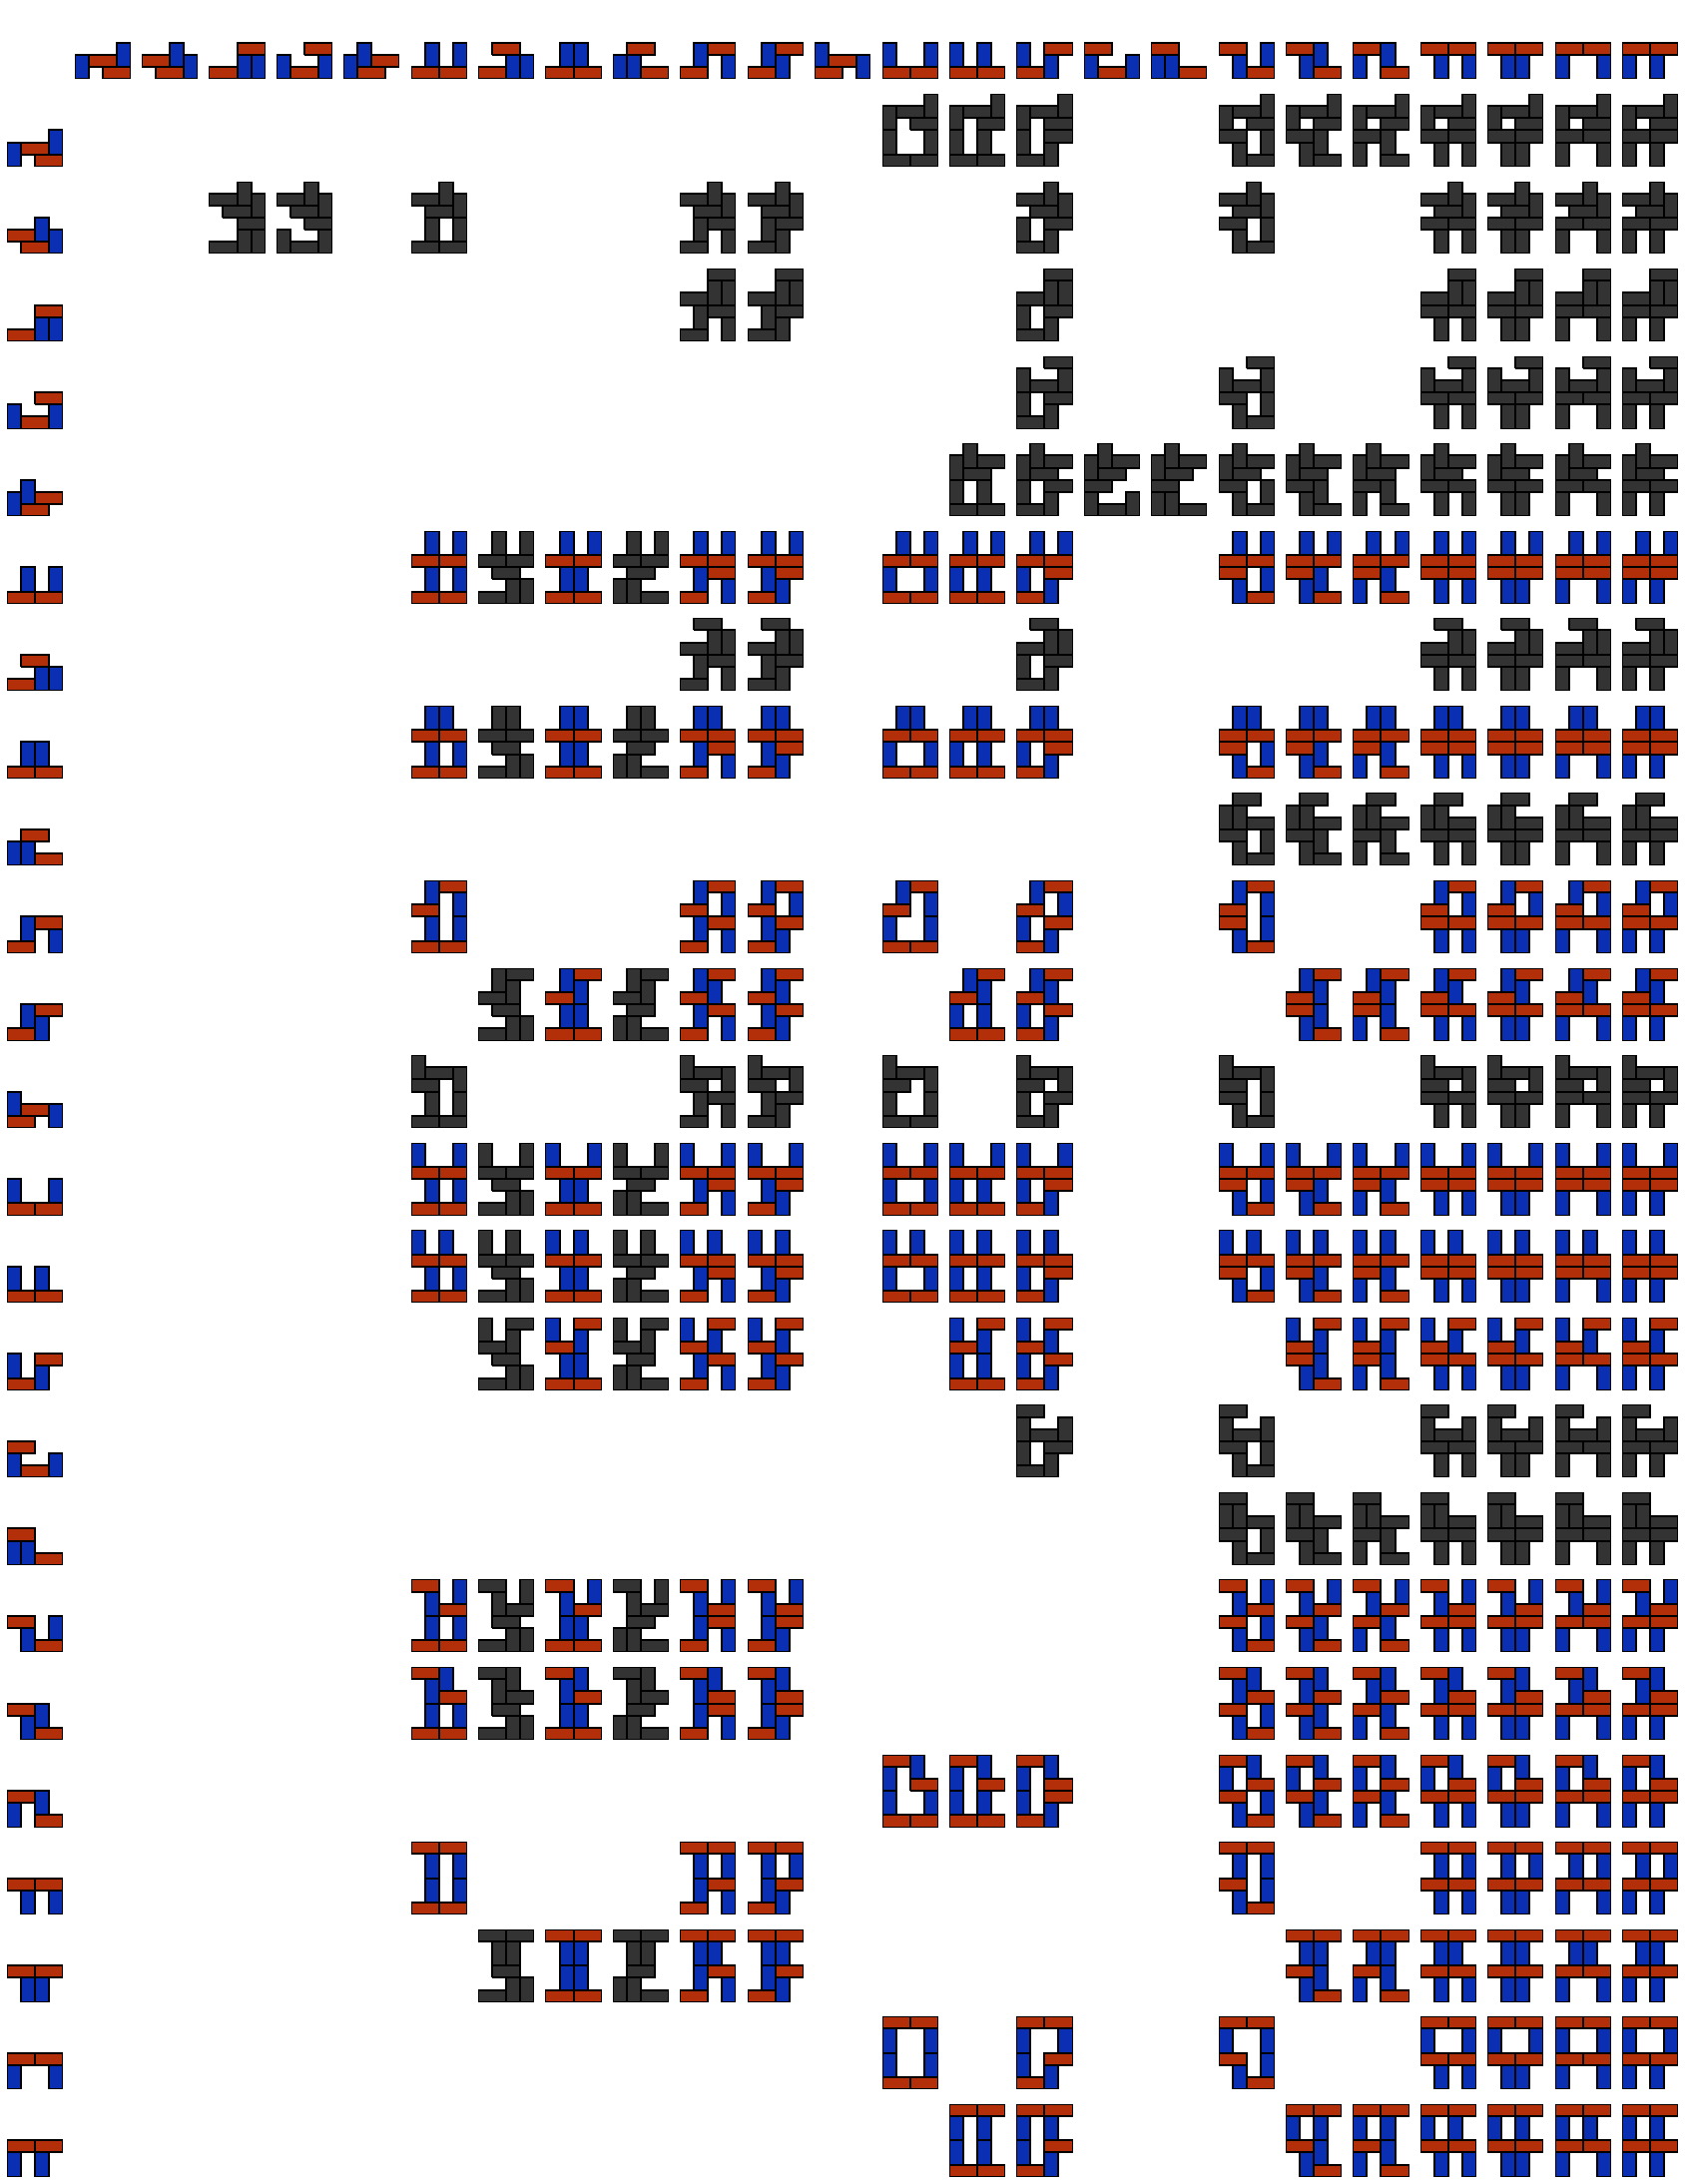

In [34]:
# attempt at coloring towers

n_towers = vert_composition_wide_subset_w4.shape[0]

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 40))

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    #grab tower
    world = utils.worldify(wide_subset_w4['stim'][i], 
                           block_dims = block_dims, 
                           block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
# iterate over towers
for i in range(0, n_towers):
    for j in range(0, n_towers):
        if vert_composition_wide_subset_w4[i,j,0]:
            world = vert_composition_wide_subset_w4[i,j,1]
            if utils.convert_to_str(world.block_map) in horz_maps_w2:
                utils.tower_subplot(utils.patches_for_world(world.blocks), 
                                axs[i+1,j+1])
            else:
                world_grey = utils.worldify(world.get_block_dict()['blocks'],
                                       block_dims = block_dims, 
                                       block_colors = grey)
                utils.tower_subplot(utils.patches_for_world(world_grey.blocks), 
                                axs[i+1,j+1])